In [1]:
import mne 
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import matplotlib
import numpy as np
import pickle
from glob import glob
from copy import deepcopy
import pandas as pd
from statannotations.Annotator import Annotator
from pathlib import Path

from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test, fdr_correction

from scipy.stats import ttest_1samp, sem, wilcoxon, pearsonr

import seaborn as sns

# print(matplotlib.__version__)

In [2]:
# def add_sent_on_top(ax, word_onsets, image_onset, sent_type='scenes', fontsize=20, shift=.02, mksz=50):
#     sentence_examples = {"scenes": (['un cercle', 'rouge', 'à droite', 'd\'un carré', 'bleu', ''], [('s', 'b'), ('o', 'r')]), "obj": (['un cercle', 'vert', ''], ('o', 'g'))}
#     secax_x = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
#     secax_x.set_xticks(word_onsets + image_onset)
#     xtickslabels = sentence_examples[sent_type][0] # corresponding ticks
#     secax_x.set_xticklabels(xtickslabels, fontdict={'fontsize': fontsize}, rotation="45", ha="left", va="baseline")  
#     ## Image
#     img_caracs = sentence_examples[sent_type][1]
#     ax_img_onset = ax.transLimits.transform((image_onset[0], 0))[0] # self.transLimits is the transformation that takes you from data to axes coordinates
#     if sent_type == "scenes":
#         ax.scatter(ax_img_onset-shift, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[0][0], color=img_caracs[0][1], s=mksz)
#         ax.scatter(ax_img_onset+shift, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[1][0], color=img_caracs[1][1], s=mksz)
#     elif sent_type == "obj":
#         ax.scatter(ax_img_onset, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[0], color=img_caracs[1], s=mksz)
#     return secax_x
def add_sent_on_top(ax, word_onsets, image_onset, colors=[], sent_type='scenes', fontsize=20, shift=.02, mksz=50):
    sentence_examples = {"scenes": (['Shape#1', 'Color#1', 'Relation', 'Shape#2', 'Color#2'], ["Image"]),
                        "img": ([], ["Image"])} #["Visual\n scene"])}
                                                                                                   #, "obj": (['un cercle', 'vert', ''], ('o', 'g'))}
    secax_x = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
    secax_x.set_xticks(word_onsets + image_onset)
    xtickslabels = sentence_examples[sent_type][0] + sentence_examples[sent_type][1] # corresponding ticks
    secax_x.set_xticklabels(xtickslabels, fontdict={'fontsize': fontsize}, rotation="45", ha="left", va="baseline")  
    
    for ticklabel, tickcolor in zip(secax_x.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    
    ## Image
#     img_caracs = sentence_examples[sent_type][1]
#     ax_img_onset = ax.transLimits.transform((image_onset[0], 0))[0] # self.transLimits is the transformation that takes you from data to axes coordinates
#     if sent_type == "scenes":
#         ax.scatter(ax_img_onset-shift, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[0][0], color=img_caracs[0][1], s=mksz)
#         ax.scatter(ax_img_onset+shift, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[1][0], color=img_caracs[1][1], s=mksz)
#     elif sent_type == "obj":
#         ax.scatter(ax_img_onset, 1.05, transform=ax.transAxes, clip_on=False, marker=img_caracs[0], color=img_caracs[1], s=mksz)
    return secax_x

def smooth(x, window_len=11, window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')

    return y[(window_len//2):-(window_len//2)]

In [3]:
def get_gfp(evo):
    gfp = np.linalg.norm(evo.data, axis=0) / np.sqrt(len(evo.data))
#     gfp = np.sum(evo.data ** 2, axis=0)
#     gfp = mne.baseline.rescale(gfp, evo.times, baseline=(None, 0))
    return gfp

def get_gfp_array(evo_arr, times):
    gfp = np.sum(evo_arr ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    return gfp

def get_time_index(times, tps):
    indices = []
    for tp in tps:
        indices.append(np.argmin(np.abs(times - tp)))
    return indices
        

In [4]:

def add_diamond_on_axis(color, ax=None, x=None, y=None, markersize=8, shift_sign=0, alpha=1., zorder=1e15):
    """ convenience to add a square "diamond" on plot's axis, as if to show a single line.
    additional_shift_percent = float: percentage of the range (min to max value along the chosen axis)
    to additionally shift the arrow of. Should be tested adn checked to find optimal value.
    shift_sign = int in (0, 1): whether to inverse the shift (allows to put the triangle inside/outside of the figure)
    Useful to show a specific training time in a timegen, for example
    Do not change xmin/xmax or ymin/ymax after calling this function.
    """
    # padd the ticks on axis to leave some space to the triangles
    if ax is None:
        ax = plt.gca()
    
    additional_shift_percent = 0 # the diamond needs to be centered
    # if shift_sign: additional_shift_percent *= -1 # no need for this if = 0

    if x is not None:
        ymin, ymax = ax.get_ylim()
        shift = abs(ymin - ymax) * additional_shift_percent
        if ymin < 0: shift = -shift # inverse the sign of the shift if the value is negative
        ax.plot([x], [ymin-shift], "D", color=color, clip_on=False, markersize=markersize, markeredgewidth=1, markeredgecolor="black", alpha=alpha, zorder=zorder)
        shift = abs(ymin - ymax) * additional_shift_percent
        if ymin < 0: shift = -shift # inverse the sign of the shift if the value is negative
        ax.plot([x], [ymax+shift], "D", color=color, clip_on=False, markersize=markersize, markeredgewidth=1, markeredgecolor="black", alpha=alpha, zorder=zorder)
        ax.tick_params(axis='x', which='major', pad=12)

    if y is not None:
        xmin, xmax = ax.get_xlim()
        shift = (abs(xmin) + abs(xmax)) * additional_shift_percent
        if xmin < 0: shift = -shift # inverse the sign of the shift if the value is negative
        ax.plot([xmin+shift], [y], "D", color=color, clip_on=False, markersize=markersize, markeredgewidth=1, markeredgecolor="black", alpha=alpha, zorder=zorder)
        shift = (abs(xmin) + abs(xmax)) * additional_shift_percent
        if xmin < 0: shift = -shift # inverse the sign of the shift if the value is negative
        ax.plot([xmax-shift], [y], "D", color=color, clip_on=False, markersize=markersize, markeredgewidth=1, markeredgecolor="black", alpha=alpha, zorder=zorder)
        ax.tick_params(axis='y', which='major', pad=12)


def add_slice_line_1ax(ax, slice_time, times, data_line, mult_fac=3, alpha=.4, fill=False, stat_fill=False, fill_where=[], color='k', lw=2, h_lw=1, mksz=8, zorder=-10):
    # Draw the plots in a few steps
    data_line *= mult_fac
    ax.plot(times, data_line+slice_time, color=color, lw=lw, clip_on=False, zorder=zorder)
    ax.axhline(xmin=times[0], xmax=times[-1], y=slice_time, linewidth=h_lw, clip_on=True, color=color, zorder=zorder)
    if fill:
        ax.fill_between(times, data_line+slice_time, slice_time, alpha=alpha, clip_on=False, zorder=zorder, color=color)
    if stat_fill: # fill only when significant
        ax.fill_between(times, data_line+slice_time, slice_time, where=fill_where, color=color, alpha=alpha, clip_on=False, zorder=zorder)

    # diamond on the axis at the decoder training time
    ax.plot([slice_time], [slice_time], marker="D", color=color, clip_on=False, markersize=mksz, markeredgewidth=1, markeredgecolor="black", zorder=1e15)
    
    ax.set_yticks([]) # Remove axes details that don't play well with overlap
#     ax.set_xticks([])    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.set_xlim(times[0], times[-1])


def plot_GAT_with_slices(ave_matrix, all_matrices, ax_gat, ax_slices, train_cond, times, ylabel="AUC", cbar=True, ybar=.5, 
                         version="v1", slices=[], stat='wilcoxon', slice_ave=5, colors=[], tmin=-.5, tmax=8,
                         fontsize=12, slice_lw=3, word_lw=1, diamond_sz=8, mult_fac=5, chance=.5, sent_mksz=25):
    """ Joint plot with timegen and slices on another axis
    """
    if ybar == 0.5:
        vmin, vcenter, vmax = 0.4, 0.5, 0.6
    elif ybar == 0:
        vmin, vcenter, vmax = -.1, 0, 0.1
    divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    extent = [min(times), max(times), min(times), max(times)]
    ax_gat.imshow(ave_matrix, norm=divnorm, cmap='bwr', origin='lower', extent=extent, zorder=0)
    ax_gat.set_xlabel("Testing time (s)", fontsize=fontsize)
    ax_gat.set_ylabel("Training time (s)", fontsize=fontsize)
    ax_gat.set_xlim(tmin, tmax); ax_slices.set_xlim(tmin, tmax)
    ax_gat.set_ylim(tmin, tmax)
    
    if cbar:
#         cbar_ax = fig.add_axes([0.4, 0.46, 0.06, 0.02])  # position for the colorbar (horizontal) - decoding on the bottom
#         cbar_ax = fig.add_axes([0.4, 0.94, 0.06, 0.02])  # position for the colorbar (horizontal) - decoding on top 
#         cbar_ax = fig.add_axes([0.41, 0.49, 0.06, 0.02])  # position for the colorbar (horizontal) - decoding on top with 2 lines above
        cbar_ax = fig.add_axes([0.078, 0.425, 0.06, 0.02])  # position for the colorbar (horizontal) - decoding on top with 2 lines above
        mappable = [qwe for qwe in ax_gat.get_children() if isinstance(qwe, matplotlib.image.AxesImage)][0] # get mappable
        # step = np.around((vmax-vmin) / 2, 1)
        # ticks = np.arange(vmin, vmax+0.01, step)
        ticks = [vmin, int(vcenter), vmax] if vcenter==0 else [vmin, vcenter, vmax] # little hack, change if more ticks are needed
        cbar = fig.colorbar(mappable, cax=cbar_ax, ticks=ticks, orientation='horizontal') # vertical
        # cbar_ax.yaxis.set_ticks_position('right') # left
        cbar_ax.set_title(ylabel, fontsize=fontsize, pad=fontsize/1.4)
        cbar.ax.tick_params(labelsize=fontsize/1.4)

    cmap = plt.cm.get_cmap('plasma', len(slices))
    for i_slice, sli in enumerate(slices): # each slice
        print(i_slice, sli)
        color = cmap(i_slice)
        add_diamond_on_axis(color=color, x=None, y=sli, ax=ax_gat, zorder=50, markersize=diamond_sz) # diamond on gat
        if stat:
            signif = get_signif(get_slice(all_matrices, times, sli, slice_ave=slice_ave, dim=1), stat, chance=chance)
            stat_fill = True
        else:
            signif = None
            stat_fill = False
        ave_slice_data = get_slice(ave_matrix, times, sli, slice_ave=slice_ave, dim=0)
        
        start, stop = (np.abs(times - tmin)).argmin(), (np.abs(times - tmax)).argmin()
        add_slice_line_1ax(ax_slices, sli, times[start:stop], ave_slice_data[start:stop]-ybar, color=color, stat_fill=stat_fill, fill_where=signif[start:stop], zorder=-10-len(slices)-i_slice, lw=slice_lw, h_lw=word_lw, mksz=diamond_sz, mult_fac=mult_fac) # higher zorder for the firsts slices so that they are on top

    ## vline at each word onset
    for w_onset in word_onsets:
        ax_gat.axvline(x=w_onset, color='k', linestyle='-', alpha=.5, lw=word_lw)
        ax_gat.axhline(y=w_onset, color='k', linestyle='-', alpha=.5, lw=word_lw)
        ax_slices.axvline(x=w_onset, color='k', linestyle='-', alpha=.5, lw=word_lw, ymin=times[0], ymax=1.01)
    for img_onset in image_onset:
        ax_gat.axvline(x=img_onset, color='k', linestyle='-', alpha=.5, lw=word_lw)
        ax_gat.axhline(y=img_onset, color='k', linestyle='-', alpha=.5, lw=word_lw)
        ax_slices.axvline(x=img_onset, color='k', linestyle='-', alpha=.5, lw=word_lw, ymin=times[0], ymax=1.01)

    # bottom labels
    ax_slices.set_xlabel("Testing time (s)", fontsize=fontsize)
    ax_slices.tick_params(axis='both', which='major', labelsize=fontsize, bottom=True, left=True)
    ax_gat.tick_params(axis='both', which='major', labelsize=fontsize, bottom=True, left=True)

    # copy the xaxis on the top to show an example sentence
    for ax in [ax_slices]: # ax_gat, 
        secax_x = add_sent_on_top(ax, word_onsets, image_onset, colors=colors, sent_type=train_cond, fontsize=fontsize, mksz=sent_mksz)
        secax_x.spines['top'].set_visible(False)

def back2fullname(name):
    name = name.replace('R', 'Relation')
    name = name.replace('C', 'Colour')
    name = name.replace('S', 'Shape')
    name = name.replace('All1stObj', 'First Object')
    name = name.replace('All2ndObj', 'Second Object')
    name = name.replace('1', ' #1')
    name = name.replace('2', ' #2')
    name = name.replace('Colour', 'Color')
    name = name.replace('ColorMismatch', 'Color Mismatch')
    name = name.replace('ShapeMismatch', 'Shape Mismatch')
# label2text = {'C': "Color", 'S': "Shape", 'S1': "First shape", 'S2': "Second shape", 'C1': "First color", 'C2': "Second Color", 'R': "Relation"}
    return name
        
def get_slice(data, times, sli, slice_ave, dim=0):
    ''' Get a slice from a matrix, from given dimension
    and average with surrounding slice_ave lines to make it smoother
    '''
    slice_time = (np.abs(times - sli)).argmin()
    if dim == 0:
        slice_data = np.mean(data[slice_time-slice_ave:slice_time+slice_ave], 0)
    elif dim == 1:
        slice_data = np.mean(data[:, slice_time-slice_ave:slice_time+slice_ave], 1)
    elif dim == 2:
        slice_data = np.mean(data[:, :, slice_time-slice_ave:slice_time+slice_ave], 2)
    return slice_data

def get_signif(all_subs_data, stat, chance=.5):
    ## all_subs_data should be (n_subs, n_times)
    assert len(all_subs_data.shape)==2, f"all_subs_data should be of shape (n_subs, n_times) but found {all_subs_data.shape}"
    n_subs, n_times = all_subs_data.shape
    # compute stats
    if stat == "cluster": # for cluster perm test we store the clusters and corresponding pvalues
        fvalues, clusters, cluster_pvals, H0 = permutation_cluster_1samp_test(all_subs_data-chance, 
                                        n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')
        signif = np.ones(n_times)
        for cluster, cluster_pval in zip(clusters, cluster_pvals):
            if cluster_pval < 0.1:
                print(f"found cluster from {times[cluster[0]][0]} to {times[cluster[-1]][-1]}")
                signif[cluster] = 0
                # print(f"signif cluster for {times[i_dat][cluster][0]:.02} to {times[i_dat][cluster][-1]:.02}s, pval={cluster_pval}")
    elif stat == "wilcoxon": # for wilcoxon we only store the pvalue for each timesample
        signif = np.zeros(n_times)
        chance_array = np.ones(n_subs) * chance
        for t in range(n_times):
            np.random.seed(seed=233423)
            signif[t] = wilcoxon(all_subs_data[:, t], chance_array, alternative="greater")[1] #two-sided
    else: 
        raise RuntimeError(f"Unknown stat method to get significant timepoints: {stat}")
    signif = fdr_correction(np.array(signif), alpha=0.05)[0]
    return signif


cmaptab10 = plt.cm.get_cmap('tab10', 10)
tab20c = plt.get_cmap("tab20c", 20)
tab20 = plt.get_cmap("tab20", 20)
tab20b = plt.get_cmap("tab20b", 20)

colors = [tab20(0), tab20(2), tab20(14), tab20b(1), tab20c(4)]

In [5]:
## Evokeds plots loading data
fns = [ "./evo_data/data/complexity0-grand-ave.fif",
        "./evo_data/data/complexity1-grand-ave.fif",
        "./evo_data/data/complexity2-grand-ave.fif"]
comp_grand_evos = [mne.read_evokeds(fn, verbose=False) for fn in fns] # list of 3 grand evokeds, on per complexity level
# comp_grand_data = [evo.data for evo in comp_grand_evos]
## complexity regression loading data
# fn = "./Regression_Decoding_v29/all/all_data.p"
fn = "./Regression_Decoding_v34/all_data.p"
regression_auc = pickle.load(open(fn, "rb"))['Complexity_scenes_None_']
# print(regression_auc.shape) # n_subs * n_times * n_times

## prepare evoked data
nchan = 306
overall_mean = np.mean([evo[0].data for evo in comp_grand_evos])
new_evos = []
for evo in comp_grand_evos:
    data = evo[0].data
    data -= overall_mean
    for i in range(nchan):
        data[i] = smooth(data[i], 9)
    new_evos.append([mne.EvokedArray(data, evo[0].info, tmin=evo[0].tmin)])
comp_grand_evos = new_evos
times = comp_grand_evos[0][0].times

## all_diags loading
# fn = "./Decoding_ovr_v29_ALL/all_diags.p"
fn = "./Decoding_ovr_v29_newnew/all_diags.p"
all_diags = pickle.load(open(fn, "rb"))

In [6]:
# plotting all properties decoding + complexity on top 

def plot_all_diags(ax, all_diags, times, labels, colors, tmin=-.5, tmax=7, ylabel="AUC", xlabel="Time (s)", hline=.5, alpha_fill=.3, lw=2, smoothing=7, ftsz=8, xticks=True):
    ax.axhline(y=hline, color='grey') # chance hline
    for won in [0, .6, 1.2, 1.8, 2.4, 5]:
        ax.axvline(x=won, color='grey') # stim onsets
    for k, c in zip(labels, colors):
        dat, std = np.mean(all_diags[k], 0), sem(all_diags[k], 0)
        dat = smooth(dat, smoothing)
        ax.plot(times, dat, label=back2fullname(k.split("_")[0]), color=c, lw=lw)
    #     ax.fill_between(times, dat-std, dat+std, alpha=0.4, zorder=-1, lw=0, color=c, clip_on=True)
        _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(all_diags[k]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
        for cluster, pval in zip(clusters, cluster_p_values):
            if pval < 0.1:
                ax.fill_between(times[cluster], hline, dat[cluster], alpha=alpha_fill, zorder=-1, lw=0, color=c, clip_on=True)

        ax.set_xlim(tmin, tmax)
    for spine in ['bottom', 'top', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=ftsz)
    ax.tick_params(axis='both', which='minor', labelsize=ftsz)
    if not xticks:
        ax.set_xticks([])
    ax.set_xlabel(xlabel, fontsize=ftsz)
    ax.set_ylabel(ylabel, fontsize=ftsz)
         
# ## Regression performance OLD PLOT}
# ax_twin = ax.twinx()
# ax_twin.plot(times, np.diag(np.mean(regression_auc,0)), c='k', label="Complexity")
# ax_twin.set_ylabel("R")
# reg_diags = np.array([np.diag(x) for x in regression_auc])
# _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(reg_diags, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
# for cluster, pval in zip(clusters, cluster_p_values):
#     if pval < 0.05:
#         ax_twin.fill_between(times[cluster], 0, np.diag(np.mean(regression_auc,0))[cluster], alpha=alpha_fill, zorder=-1, lw=0, color='k', clip_on=True)            

def make_img(ax, x, y, img_caracs=[('s', 'b'), ('o', 'r')], shift=.02, mksz=50):
#     ax_img_onset = ax.transLimits.transform((x, 0))[0] # self.transLimits is the transformation that takes you from data to axes coordinates
#     ax.scatter(ax_img_onset-shift, y, transform=ax.transAxes, clip_on=False, marker=img_caracs[0][0], color=img_caracs[0][1], s=mksz)
#     ax.scatter(ax_img_onset+shift, y, transform=ax.transAxes, clip_on=False, marker=img_caracs[1][0], color=img_caracs[1][1], s=mksz)
#     ax_img_onsets = ax.transLimits.transform((x, y)) # self.transLimits is the transformation that takes you from data to axes coordinates
    ax_img_onsets = [x,y]
    ax.scatter(ax_img_onsets[0]-shift, ax_img_onsets[1], clip_on=False, marker=img_caracs[0][0], color=img_caracs[0][1], s=mksz)
    ax.scatter(ax_img_onsets[0]+shift, ax_img_onsets[1], clip_on=False, marker=img_caracs[1][0], color=img_caracs[1][1], s=mksz)

def add_text(ax, x, y, txt, color, fontsize=20):
#     onsets = ax.transLimits.transform((x, y)) # self.transLimits is the transformation that takes you from data to axes coordinates
    onsets = [x, y]
    ax.text(onsets[0], onsets[1], txt, color=color, fontsize=fontsize)
    

/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/514985421.py:12: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(all_diags[k]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/514985421.py:12: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(all_diags[k]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/514985421.py:12: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(all_diags[k]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
/var/folders/xy/4hzstcbn00bft6pkgf

0 3.2


/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/2166096879.py:160: RuntimeWarning: joblib not installed. Cannot run in parallel.
  n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')


found cluster from 2.95 to 3.85
1 4.0


/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/2166096879.py:160: RuntimeWarning: joblib not installed. Cannot run in parallel.
  n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')


found cluster from 3.45 to 5.67
2 4.8


/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/2166096879.py:160: RuntimeWarning: joblib not installed. Cannot run in parallel.
  n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')


found cluster from 3.56 to 5.66
3 5.6


/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/2166096879.py:160: RuntimeWarning: joblib not installed. Cannot run in parallel.
  n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')


found cluster from 3.61 to 5.16
found cluster from 5.2 to 5.93
4 6.5


/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/2166096879.py:160: RuntimeWarning: joblib not installed. Cannot run in parallel.
  n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')


found cluster from 3.68 to 4.96
found cluster from 5.01 to 5.65
found cluster from 5.82 to 7.36


/Users/polo/miniconda3/envs/Neuron/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


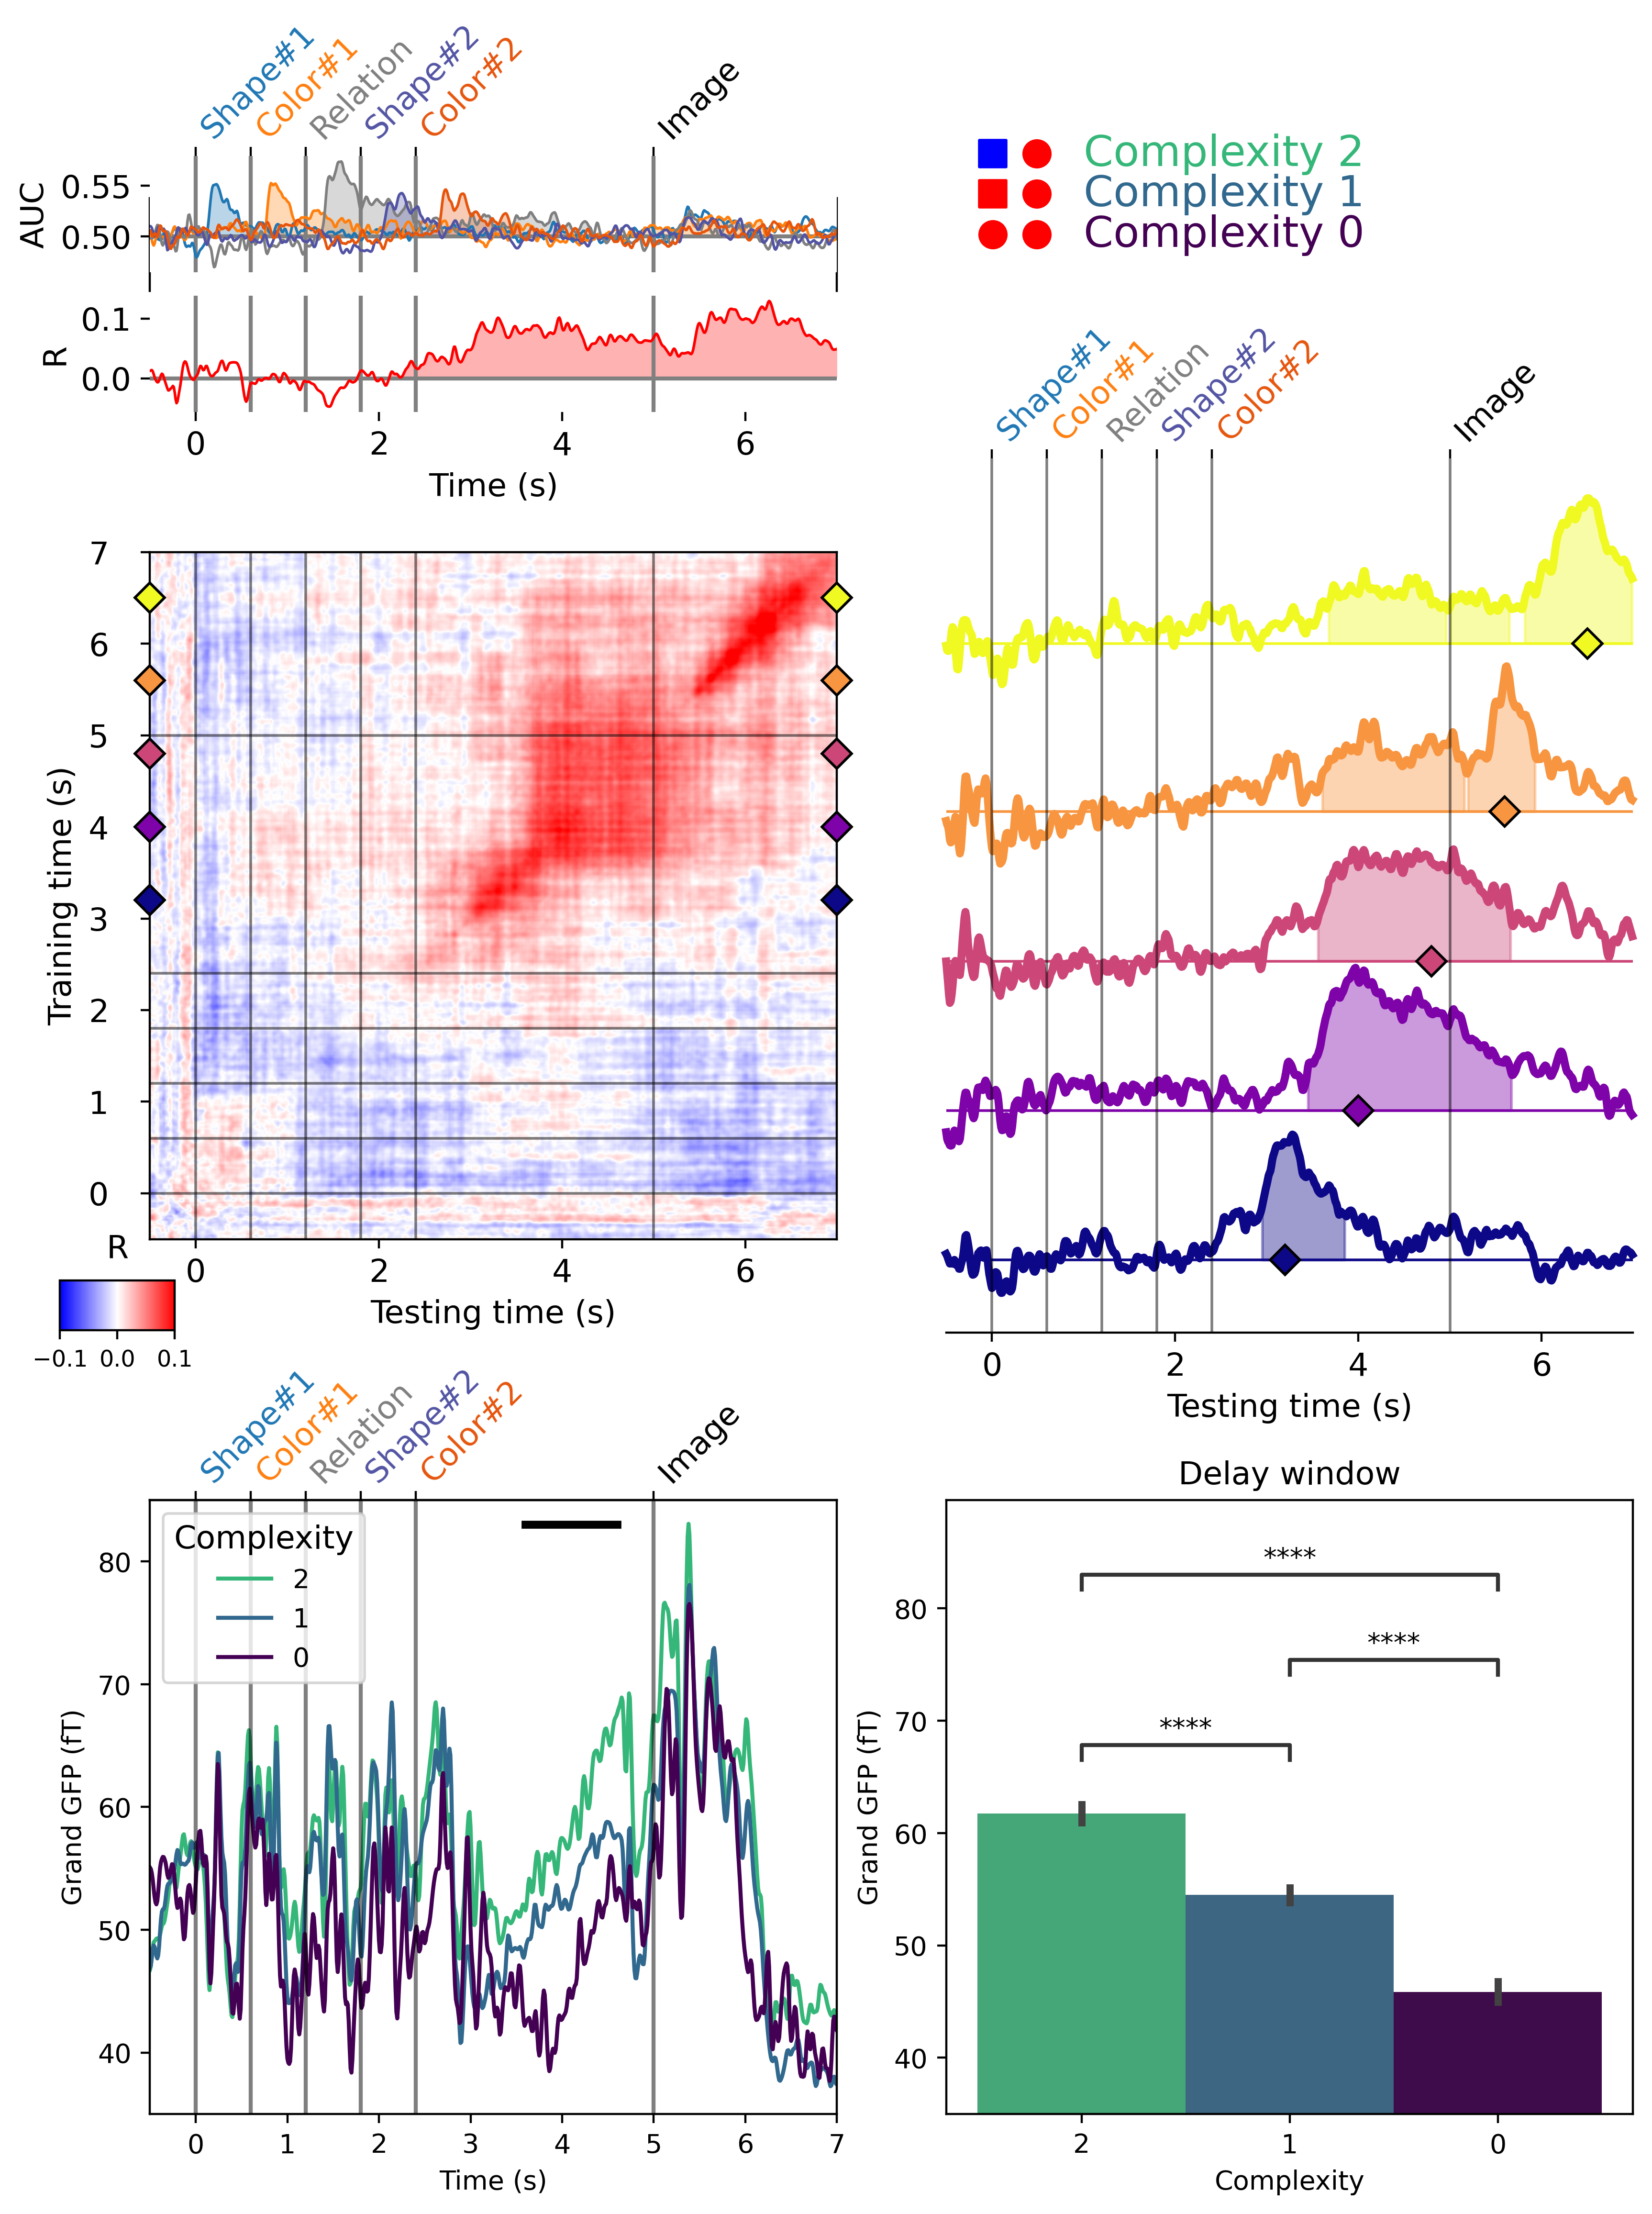

In [7]:
## complexity plot 
word_onsets, image_onset = [.6*i for i in range(5)], [5.]
ftsz = 12
sent_mksz = 50
tmin, tmax = -.5, 7
np.random.seed(42)
colors = [tab20(0), tab20(2), tab20(14), tab20b(1), tab20c(4)]
# fig, axes = plt.subplots(2, 2, dpi=400)
fig = plt.figure(constrained_layout=True, dpi=400, figsize=(10,13))
axes = fig.subplot_mosaic("""ZZZXXX
                             DDDEEE
                             DDDEEE
                             DDDEEE
                             DDDEEE
                             AAABBB
                             AAABBB
                             AAABBB""")

labels = ["S1_scenes_None_", "C1_scenes_None_", "R_scenes_None_", "S2_scenes_None_", "C2_scenes_None_"]
colors = [tab20(0), tab20(2), tab20(14), tab20b(1), tab20c(4)]
ax_lin = axes["Z"]
ax_lin.set_visible("False")
axX = ax_lin.inset_axes([0, 0.2, 1, 1.25])
plot_all_diags(axX, all_diags, times, labels, colors, tmin=tmin, tmax=tmax, xticks=False, ylabel="AUC", xlabel="", hline=.5, alpha_fill=.3, lw=1, smoothing=7, ftsz=ftsz)
secax_x = add_sent_on_top(axX, word_onsets, image_onset, colors=colors, sent_type='scenes', fontsize=ftsz, mksz=sent_mksz)
secax_x.spines['top'].set_visible(False)
axY = ax_lin.inset_axes([0, -1.3, 1, 1.25], clip_on=False)
reg_diags = {"Complexity": np.array([np.diag(x) for x in regression_auc])}
plot_all_diags(axY, reg_diags, times, ["Complexity"], ["red"], tmin=tmin, tmax=tmax, ylabel="R", xlabel="Time (s)", hline=0, alpha_fill=.3, lw=1, smoothing=7, ftsz=ftsz)
ax_lin.set_visible("False")
ax_lin.get_xaxis().set_visible(False)
ax_lin.get_yaxis().set_visible(False)
ax_lin.spines.top.set_visible(False); axes["Z"].spines.bottom.set_visible(False)
axX.spines.top.set_visible(False); axX.spines.bottom.set_visible(False)
axX.spines.left.set_visible(False); axX.spines.right.set_visible(False)

ax_lev = axes["X"]
ax_lev.axis('off')
cmap_gfp = plt.get_cmap("viridis", 4)
x_txt = 0.2
mksz, shift, yshift, yoffset = 100, .032, .3, .5
ax_lev.set_xlim(0, 1)
ax_lev.set_ylim(-.9, 1.4)
make_img(ax_lev, x=.1, y=2+yoffset, img_caracs=[('s', 'b'), ('o', 'r')], shift=shift, mksz=mksz)
add_text(ax_lev, x=x_txt,y=2-yshift+yoffset, txt="Complexity 2", color=cmap_gfp(2), fontsize=ftsz+4)
make_img(ax_lev, x=.1, y=1+yoffset, img_caracs=[('s', 'r'), ('o', 'r')], shift=shift, mksz=mksz)
add_text(ax_lev, x=x_txt,y=1-yshift+yoffset, txt="Complexity 1", color=cmap_gfp(1), fontsize=ftsz+4)
make_img(ax_lev, x=.1, y=0+yoffset, img_caracs=[('o', 'r'), ('o', 'r')], shift=shift, mksz=mksz)
add_text(ax_lev, x=x_txt,y=0-yshift+yoffset, txt="Complexity 0", color=cmap_gfp(0), fontsize=ftsz+4)

# cmap_gfp = plt.get_cmap("viridis", 4)
## top left: GFP
ax_gfp = axes["A"]
ymin, ymax = 35, 85 # , ylim={'mag':(ymin,None)} # truncate_yaxis
# figevo = mne.viz.plot_compare_evokeds(comp_grand_evos, combine='gfp', legend=False, axes=[ax_gfp], title='', show=False, picks='mag', vlines=[]) #, show_sensors='upper right')
comp4plot = [comp_grand_evos[2], comp_grand_evos[1], comp_grand_evos[0]]
GFPs = [get_gfp(deepcopy(evo[0]).pick('mag')) for evo in comp4plot]
for i, gfp in enumerate(GFPs):
    ax_gfp.plot(times, gfp*1e15, label=i, color=cmap_gfp(2-i))
ax_gfp.set_ylim(ymin, ymax)
ax_gfp.set_xlim(tmin, tmax)
ax_gfp.set_ylabel("Grand GFP (fT)")
ax_gfp.set_xlabel("Time (s)")
handles, labels = axes["A"].get_legend_handles_labels()
ax_gfp.legend(handles=handles, labels=['2', '1', '0'], title='Complexity', loc='upper left', prop={'size': 10}, title_fontsize=ftsz)
for w_onset in word_onsets:
    ax_gfp.axvline(x=w_onset, linestyle='-', color='k', alpha=.5)
for img_onset in image_onset:
     ax_gfp.axvline(x=img_onset, linestyle='-', color='k', alpha=.5)
secax_x = add_sent_on_top(ax_gfp, word_onsets, image_onset, colors=colors, sent_type='scenes', fontsize=ftsz, mksz=sent_mksz)
_, ymax = ax_gfp.get_ylim() # # signif hlines
l = ax_gfp.plot([3.6, 4.6], [ymax-2, ymax-2], color='k', lw=3) ## window 

## Top right: bar plot GFP
ax_bar1 = axes["B"]
window1 = [3.6, 4.6]
ax_bar1.set_title(f"Delay window", fontsize=ftsz)
start, stop = get_time_index(times, window1)
cropped_gfps = [gfp[start:stop] for gfp in GFPs]
dict_df = {"Complexity": [], "GFP": []}
for comp, dat in enumerate(cropped_gfps):
    for d in dat:
        if np.random.choice([0,0,0,0,1]):
            dict_df["Complexity"].append(str(comp))
            dict_df["GFP"].append(d * 1e15) # put in femtoTesla
df = pd.DataFrame.from_dict(dict_df)
# df.sort_values('Complexity', ascending=False).reset_index()
palette = {"0": cmap_gfp(2), "1": cmap_gfp(1), "2": cmap_gfp(0)}
sns.barplot(data=df, x="Complexity", y="GFP", ax=ax_bar1, width=1, errorbar='se', palette=palette) # , order=['2','1','0']
# pairs=[("0", "1"), ("0", "2"), ("1", "2")]
pairs=[("2", "1"), ("2", "0"), ("1", "0")]
annotator = Annotator(ax_bar1, pairs, data=df, x="Complexity", y="GFP", order=['2','1','0'], palette=palette) #, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
annotator.apply_and_annotate()
ax_bar1.set_ylabel("Grand GFP (fT)")
ax_bar1.set_ylim(ymin)
ax_bar1.set_xticklabels([2, 1, 0])

## timegen complexity regression
slices = [3.2, 4., 4.8, 5.6, 6.5]
ax_gat, ax_slices = axes["D"], axes["E"]
plot_GAT_with_slices(np.mean(regression_auc,0), regression_auc, ax_gat, ax_slices, 'scenes', times, ylabel="R", 
                         version="v2", slices=slices, stat='cluster', slice_ave=5, colors=colors, tmin=tmin, tmax=tmax,
                         fontsize=ftsz, slice_lw=3, word_lw=1, diamond_sz=8, mult_fac=8, chance=0, ybar=0, sent_mksz=sent_mksz)

plt.subplots_adjust(hspace=1.8, wspace=0.7)
# plt.tight_layout()
fig.savefig("./complexity_plot.png", transparent=True, bbox_inches='tight', dpi=400)

In [8]:
all_onsets ={"scenes": [.6*i for i in range(5)], "obj": [.6*i for i in range(2)], "loc": [0]}
tstops = {"loc": 1., "obj": 2.2, "scenes": 5}

# facecolors = {"loc": 'white', "obj": 'grey', "scenes": 'k'} # not working

def joyplot_with_stats(axes, data_dict, colors, tmin=-.3, tmax=5, labels=[], \
                    fsz=16, title_fsz=26, stat='wilc', threshold=0.01, y_inc=0.05, hline=.5, smoothing=7):
    """ To plot multiple decoders diagonals on the same plot
    one per subplot, with statistics
    """
    if not np.all([lab in data_dict.keys() for lab in labels]):
        print(f"!!! Could not find key(s) {[lab for lab in labels if lab not in data_dict.keys()]} in the data_dict")
        return

    if len(labels) == 1: axes = [axes]
    for i, k in enumerate(labels):
        cond = "loc" if "loc" in k else "scenes" if "1" in k or "2" in k or "R" in k else "obj"
        tstop = tstops[cond]
        times = all_times[cond]
        onsets = all_onsets[cond]
        c = colors[i]
        for onset in onsets:
            axes[i].axvline(x=onset, linestyle='-', color='k', lw=1, clip_on=True, ymin=0.2, ymax=.9) # 
        axes[i].axhline(y=hline, xmin=tmin, xmax=tmax, color='k', linestyle='-', alpha=.7, lw=0.5)

        dat, std = np.mean(data_dict[k], 0), sem(data_dict[k], 0)
        if smoothing:
            dat = smooth(dat, smoothing)
        time_mask = np.logical_and(tmin<=times, times<=tstop)
        dat, std, local_times = dat[time_mask], std[time_mask], times[time_mask]
        axes[i].plot(local_times, dat, lw=3, c=c, clip_on=False, alpha=1)
        axes[i].fill_between(local_times, dat-std, dat+std, alpha=0.4, zorder=-1, lw=0, color=c, clip_on=False)

        np.random.seed(seed=23323)
        if stat in ["wilc", "wilcoxon"]:
            signif = np.zeros_like(local_times)
            chance_array = np.ones_like(data_dict[k][:,0]) * hline
            for t in range(len(local_times)):
                signif[t] = wilcoxon(data_dict[k][:, time_mask][:, t], chance_array, alternative="greater")[1] #two-sided
            signif = fdr_correction(np.array(signif), alpha=0.3)[0] #.astype(bool)
            axes[i].fill_between(local_times, hline, dat, where=signif, alpha=0.9, zorder=-1, lw=0, color=c, clip_on=False)
            # axes[i].fill_between(local_times, hline, signifed_dat, alpha=0.8, zorder=-1, lw=0, color=cmaptab10(i), clip_on=False)
        elif stat == "cluster":
            _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(data_dict[k][:,time_mask]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
            for cluster, pval in zip(clusters, cluster_p_values):
                if pval < 0.05:
                    axes[i].fill_between(local_times[cluster], hline, dat[cluster], alpha=0.9, zorder=-1, lw=0, color=c, clip_on=False)
        ## Title label on the left
        axes[i].text(-0.04, .55, back2fullname(k.split("_")[0]), ha='center', va='center', transform=axes[i].transAxes, fontsize=title_fsz)
        # cosmetics
        axes[i].set_xlim(tmin, tmax)
        for spine in ['bottom', 'top', 'left', 'right']:
            axes[i].spines[spine].set_visible(False)
        axes[i].yaxis.set_label_position("right") # put yaxis on the right
        axes[i].yaxis.tick_right()
        axes[i].patch.set_alpha(0.01) # make axis transparent to allow very tight spacing between subplots
        if (i+1) < len(labels): axes[i].set_xticks([]) # keep xticks only on the bottom row
        axes[i].tick_params(axis='both', which='major', labelsize=fsz)
        axes[i].tick_params(axis='both', which='minor', labelsize=fsz)
        yticks = np.arange(.5, axes[i].get_ylim()[1], y_inc)
#         axes[i].set_yticks(yticks)
        axes[i].set_yticks(yticks if i == 0 else yticks[0:-1]) # remove last tick because it overlaps with the axis on top of it - doesnt work because axes are shared

    axes[-1].set_xlabel("Time (s)", fontsize=fsz)


In [9]:
## Figure on decoding each property
print(all_diags.keys())

times_loc = np.linspace(-.5, 1, all_diags["C_localizer_None_"].shape[-1])
times_obj = np.linspace(-.5, 4, all_diags["C_obj_None_"].shape[-1])
times_scenes = np.linspace(-.5, 8, all_diags["C1_scenes_None_"].shape[-1])
all_times = {"loc": times_loc, "obj": times_obj, "scenes": times_scenes}


dict_keys(['BindMismatch_scenes_None__for_Complexity=2', 'BindMismatch_scenes_None_', 'C_localizer_None__for_Matching=loc-match', 'C_localizer_None__for_Matching=loc-nonmatch', 'C_localizer_None_', 'C_obj_None_', 'C1_scenes_None_', 'C1_0_scenes_obj_', 'C1_1_scenes_scenes_', 'C2_scenes_None_', 'C2_0_scenes_scenes_', 'C2_1_scenes_obj_', 'C_0_localizer_obj__for_Matching=loc-match', 'C_0_localizer_obj__for_Matching=loc-nonmatch', 'C_0_localizer_obj_', 'C_0_obj_scenes_', 'C_1_localizer_scenes__for_Matching=loc-match', 'C_1_localizer_scenes__for_Matching=loc-nonmatch', 'C_1_localizer_scenes_', 'C_1_obj_scenes_', 'C_2_localizer_scenes__for_Matching=loc-match', 'C_2_localizer_scenes__for_Matching=loc-nonmatch', 'C_2_localizer_scenes_', 'Matching_scenes_None__for_Complexity=0', 'Matching_scenes_None__for_Complexity=1', 'Matching_scenes_None__for_Complexity=2', 'Matching_scenes_None_', 'PropMismatch_scenes_None__for_Complexity=0', 'PropMismatch_scenes_None__for_Complexity=1', 'PropMismatch_scene

/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/3639649221.py:44: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(data_dict[k][:,time_mask]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/3639649221.py:44: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(data_dict[k][:,time_mask]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_size=None)
/var/folders/xy/4hzstcbn00bft6pkgfqb6c680000gn/T/ipykernel_16608/3639649221.py:44: RuntimeWarning: joblib not installed. Cannot run in parallel.
  _, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(data_dict[k][:,time_mask]-hline, n_permutations=1000, threshold=1e-6, tail=1, n_jobs=-1, verbose=False, buffer_siz

REMOVE EACH YTICKS AND PUT A SINGLE SMALL LEGEND INSTEAD??


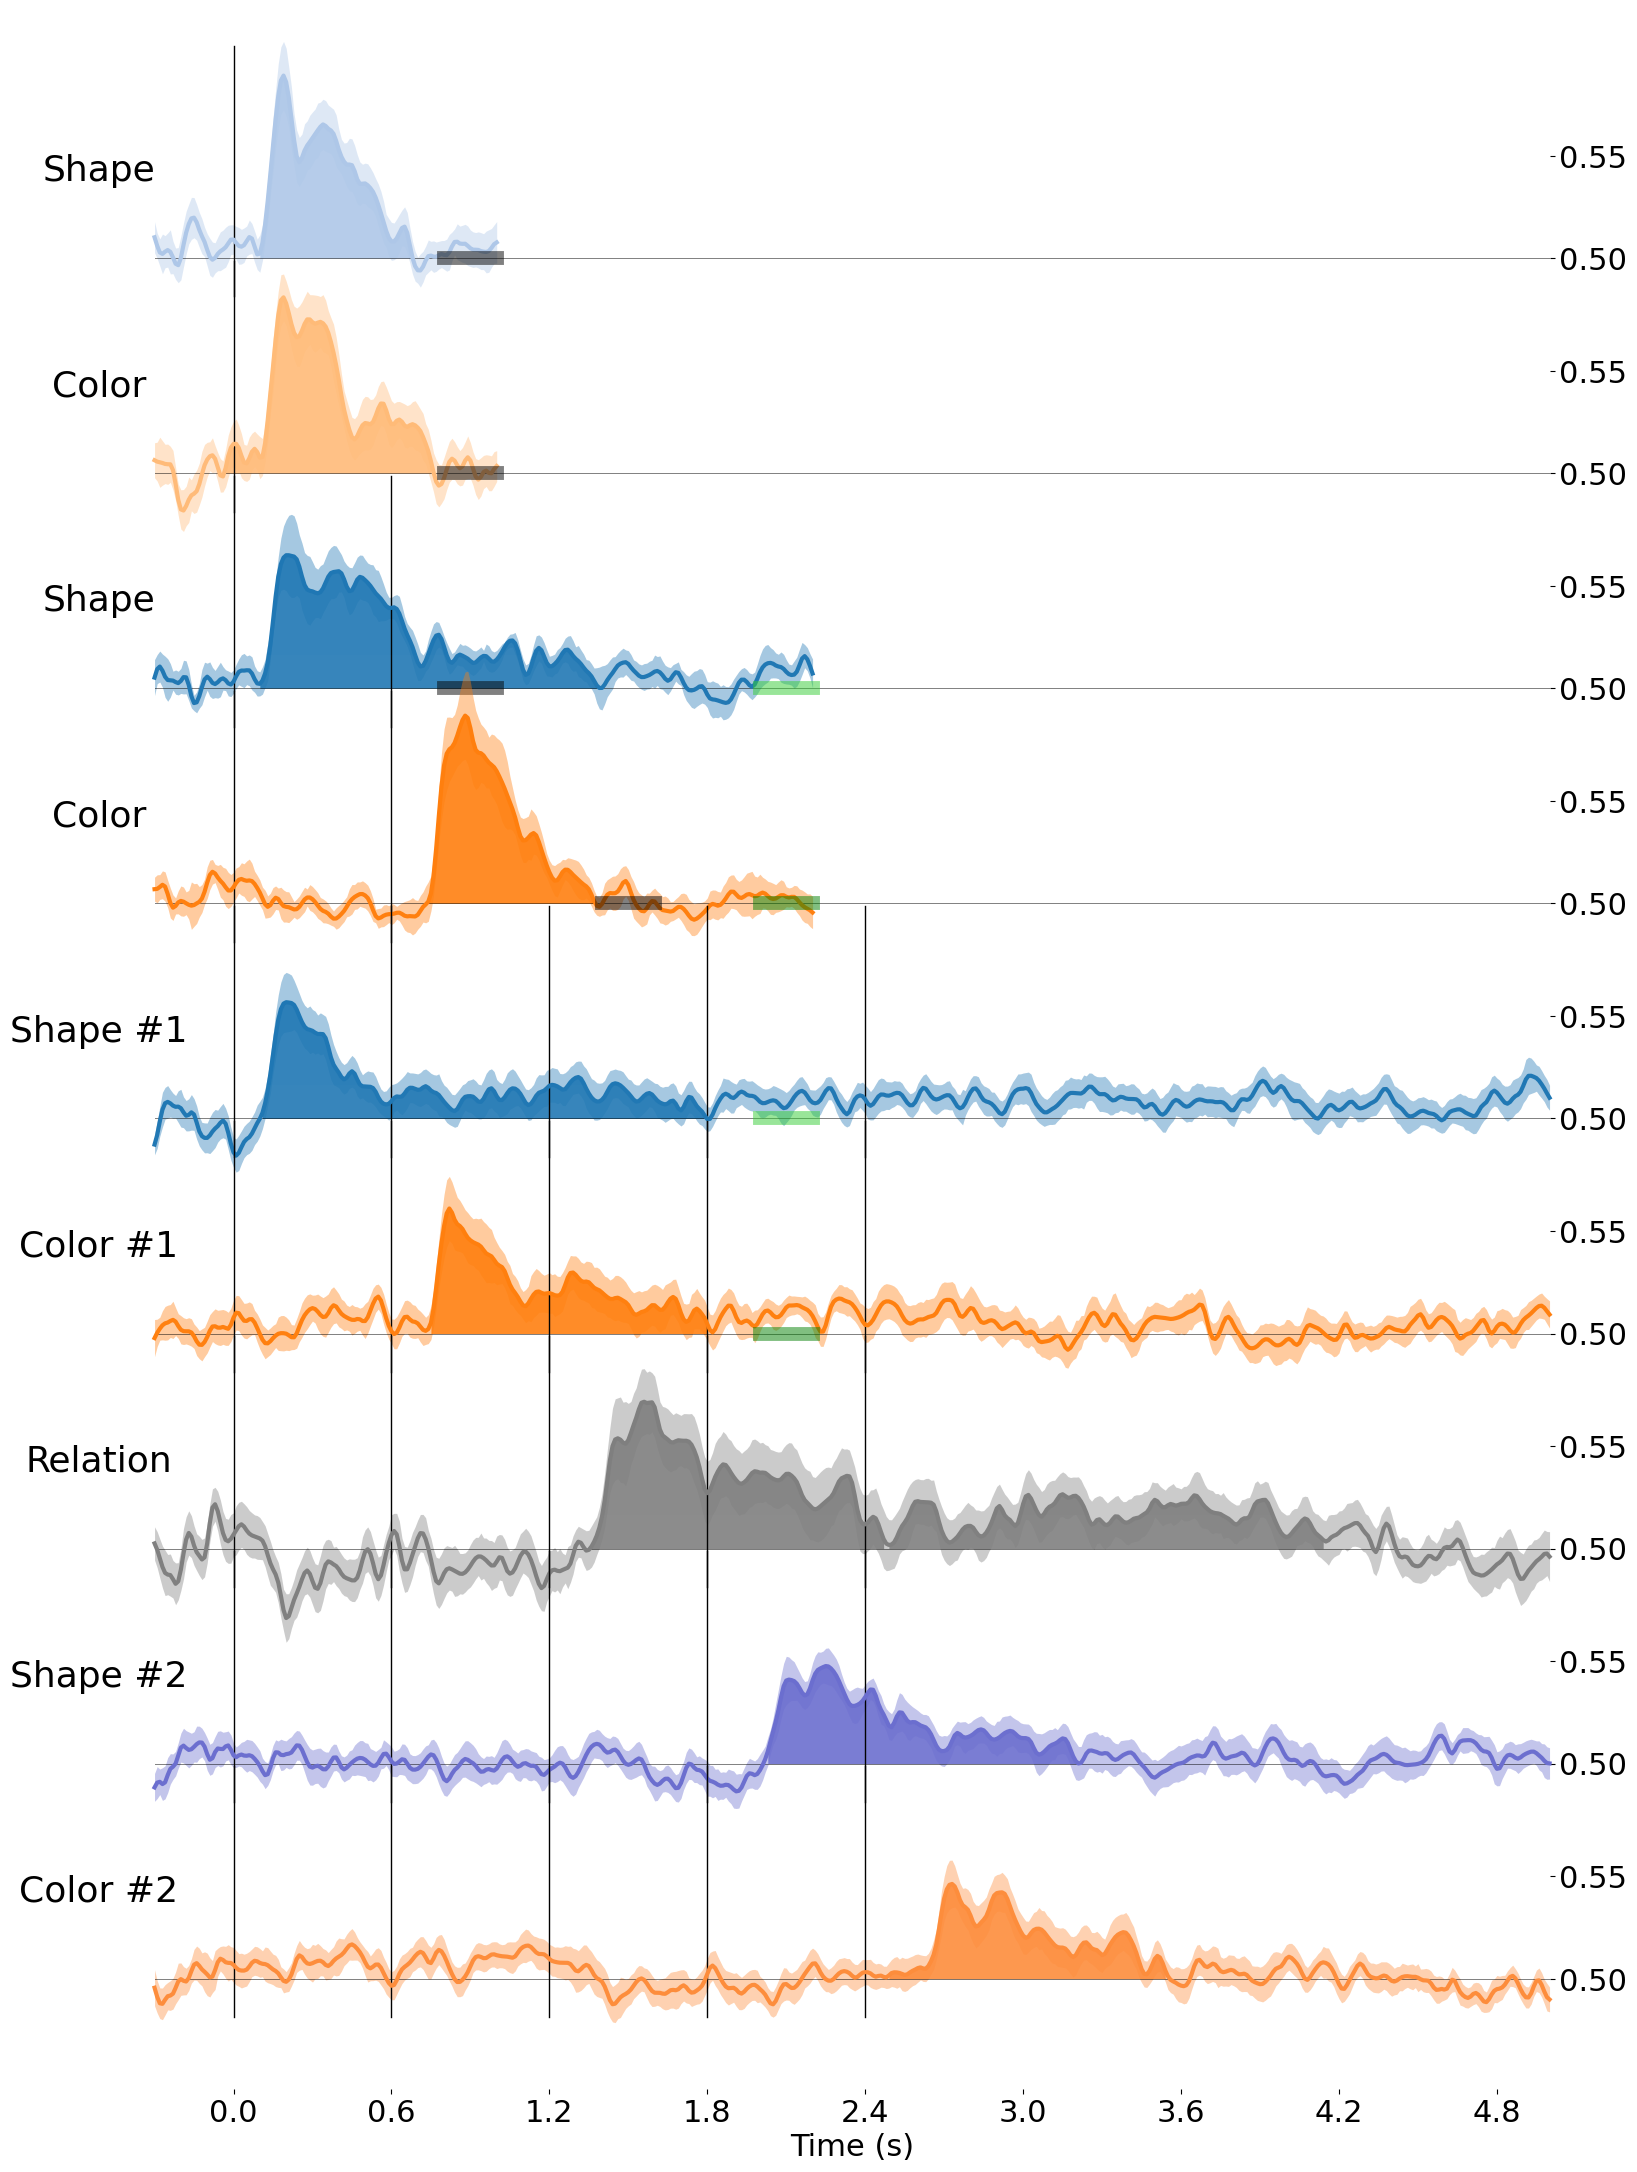

In [38]:
labels = ["S_localizer_None__for_Matching=loc-nonmatch",
#          "S_localizer_None_", 
#          "C_localizer_None_",
         "C_localizer_None__for_Matching=loc-nonmatch",
          "S_obj_None_",
          "C_obj_None_",
          "S1_scenes_None_", 
          "C1_scenes_None_",
          "R_scenes_None_", 
          "S2_scenes_None_", 
          "C2_scenes_None_"]


local_all_diags = deepcopy(all_diags) # {}
bads_shape = [0, 2, 3, 4, 6, 9, 12, 16, 18, 23] 
local_all_diags["S_obj_None_"] = np.array([x for i, x in enumerate(all_diags["S_obj_None_"]) if i in bads_shape])
bads_color = [2, 4, 6, 9, 12, 15, 17, 18, 20, 21, 22]
local_all_diags["C_obj_None_"] = np.array([x for i, x in enumerate(all_diags["C_obj_None_"]) if i in bads_color])

bads_shape1 = [0, 2, 3, 4, 6, 23] #, 9, 11, 12, 13, 14, ]  23 16
local_all_diags["S1_scenes_None_"] = np.array([x for i, x in enumerate(all_diags["S1_scenes_None_"]) if i not in bads_shape1])
bads_color1 = [2, 4, 6, 9, 12] #, 15, 17, 18, 20, 21, 22]
local_all_diags["C1_scenes_None_"] = np.array([x for i, x in enumerate(all_diags["C1_scenes_None_"]) if i not in bads_color1])

bads_shape2 = [0, 2, 4, 26]
local_all_diags["S2_scenes_None_"] = np.array([x for i, x in enumerate(all_diags["S2_scenes_None_"]) if i not in bads_shape2])
# bads_color2 = [0, 1, 2, 3, 5]
# local_all_diags["C2_scenes_None_"] = np.array([x for i, x in enumerate(all_diags["C2_scenes_None_"]) if i not in bads_sh2])

bads_r = [14, 17, 26]
local_all_diags["R_scenes_None_"] = np.array([x for i, x in enumerate(all_diags["R_scenes_None_"]) if i not in bads_r])

fig, axes = plt.subplots(len(labels), figsize=(18, len(labels)*3), sharey='col')

colors = [tab20(1), tab20(3),
          tab20(0), tab20(2),
          tab20(0), tab20(2), tab20(14), tab20b(2), tab20c(5)]

joyplot_with_stats(axes, local_all_diags, labels=labels, colors=colors,
                   fsz=22, title_fsz=26, stat='cluster', threshold=.001, y_inc=0.05, hline=.5)
axes[-1].set_xticks([0, .6, 1.2, 1.8, 2.4, 3, 3.6, 4.2, 4.8])
## markers to show where the windows are 
lw, alpha = 10, .5

# outside of plots to copy-paste on the barplot titles - DECOMMENT TO GET THE BARS 
# axes[0].plot((4,4.2), [.55,.55], lw=lw, alpha=alpha, color='k')
# # outside of plots to copy-paste on the barplot titles
# axes[0].plot((4.3,4.5), [.55,.55], lw=lw, alpha=alpha, color='limegreen')
# # outside of plots to copy-paste on the barplot titles
# axes[0].plot((4.6,4.8), [.55,.55], lw=lw, alpha=alpha, color='g')

win = (0.8, 1) # localizer or first shape -> 800ms after t0
axes[0].plot(win, [.5,.5], lw=lw, alpha=alpha, color='k')
axes[1].plot(win, [.5,.5], lw=lw, alpha=alpha, color='k')
axes[2].plot(win, [.5,.5], lw=lw, alpha=alpha, color='k')

win = (1.4, 1.6) # first color -> 800ms after color onset (600ms) = 1.4s 
axes[3].plot(win, [.5,.5], lw=lw, alpha=alpha, color='k')

win = (2, 2.2)
axes[2].plot(win, [.5,.5], lw=lw, alpha=alpha, color='limegreen')
axes[4].plot(win, [.5,.5], lw=lw, alpha=alpha, color='limegreen')

win = (2, 2.2)
axes[3].plot(win, [.5,.5], lw=lw, alpha=alpha, color='g')
axes[5].plot(win, [.5,.5], lw=lw, alpha=alpha, color='g')

# micro_ax = axes[0].inset_axes((.8, .6, .1, .1))

plt.subplots_adjust(hspace=-.4)
# plt.tight_layout()

print("REMOVE EACH YTICKS AND PUT A SINGLE SMALL LEGEND INSTEAD??")

plt.savefig("./all_decoders_timecourse.png", transparent=True, bbox_inches='tight', dpi=400)

In [31]:
# cmap_subs = plt.get_cmap("nipy_spectral", 30)
# for i, dat in enumerate(all_diags["R_scenes_None_"]):
#     fig, ax = plt.subplots(dpi=200)
#     ax.plot(times, dat)
#     ax.axhline(.5)
#     ax.set_title(i)
# # bads = [2, 4, 6, 9, 12, 15, 17, 18, 20, 21, 22]
# # goods = [0, 11, 16, 19, 23, 24, 26]
# # bads_shape = [0, 2, 3, 4, 6, 9, 12, 16, 18, 23]
# bads_r = [14, 17]

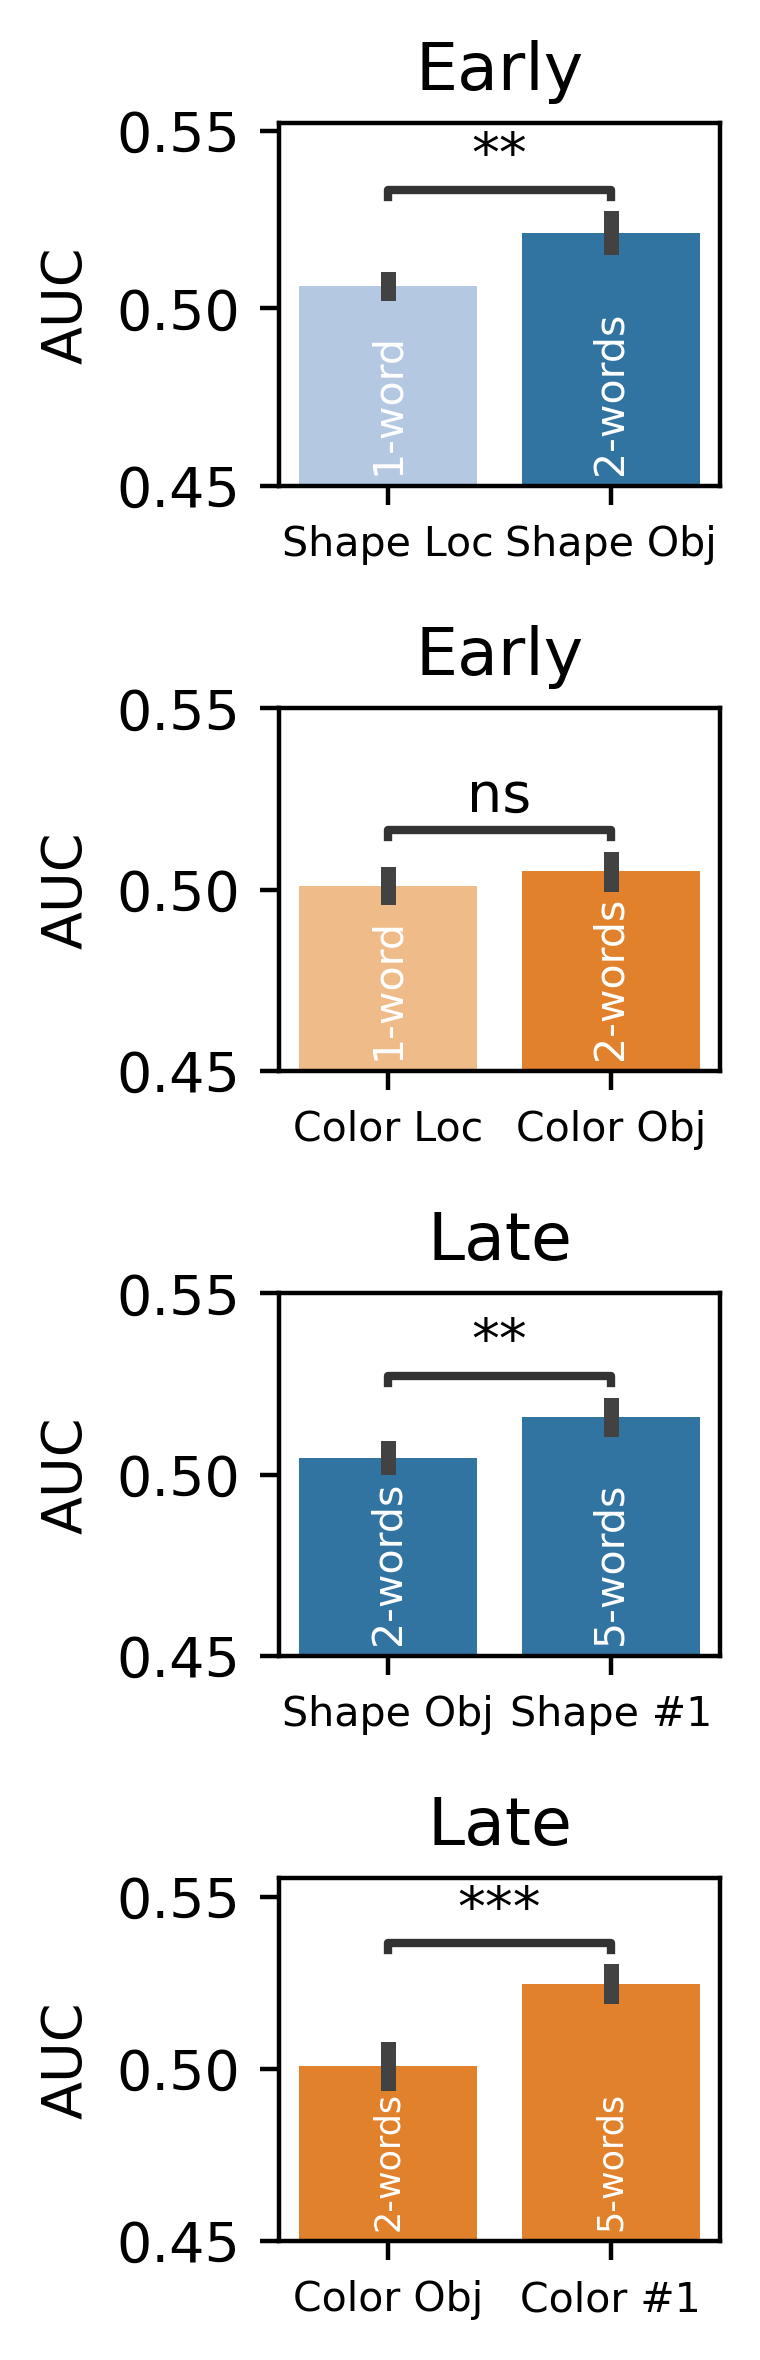

In [32]:
# barplot for sustainance
# time_to_test = 1.
fig, axes = plt.subplots(4, dpi=400, figsize=(2, 6))
width = .8
ftsz = 7.4
ymin, ymax = .45, .55

for ax in axes:
    ax.set_ylim(ymin, ymax)
## shape localizer - shape obj
win = (.8, 1)
conds = ["S_0_localizer_obj_", "S_obj_None_"]
palette = {"S_0_localizer_obj_": colors[0], "S_obj_None_": colors[2]} # {"S_0_localizer_obj_": "tab:blue", "S_obj_None_": "tab:green"}
dict_df = {"Condition": [], "AUC": []}
for i, (cond, times_train) in enumerate(zip(conds, [times_loc, times_obj])):
    start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
    dat = all_diags[cond][:, start:stop] # nsubs*len(win)
    ave_dat = np.mean(dat, 1) # average over timepoints in the timewindow. # nsubs
    for rep in range(1):
        for d in ave_dat: # data from each subject
            dict_df["Condition"].append(cond)
            dict_df["AUC"].append(d if cond == "S_0_localizer_obj_" else d+0.017)
df = pd.DataFrame.from_dict(dict_df)
sns.barplot(data=df, x="Condition", y="AUC", ax=axes[0], width=width, errorbar='se', palette=palette)
annotator = Annotator(axes[0], [(conds[0], conds[1])], data=df, x="Condition", y="AUC") #, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
annotator.apply_and_annotate()
axes[0].set_xticklabels(["Shape Loc", "Shape Obj"], fontsize=ftsz)
axes[0].set_title("Early")
for bar, label in zip(axes[0].patches, ["1-word", "2-words"]):
    axes[0].text(bar.get_x()+bar.get_width()/2, ymin+0.003, label, color='w', ha='center', va='bottom', rotation=90, fontsize=ftsz) 

    
## Shape obj - shape 1 -- 3rd plot
win = (2, 2.2)
conds = ["S_1_obj_scenes_", "S1_scenes_None_"]
palette = {"S_1_obj_scenes_": colors[2], "S1_scenes_None_": colors[2]} # {"S_1_obj_scenes_": "tab:green", "S1_scenes_None_": "tab:purple"}
dict_df = {"Condition": [], "AUC": []}
for i, (cond, times_train) in enumerate(zip(conds, [times_obj, times_scenes])):
    start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
    dat = all_diags[cond][:, start:stop] # nsubs*len(win)
    ave_dat = np.nanmean(dat, 1) # average over timepoints in the timewindow. # nsubs
    for rep in range(3):
        for d in ave_dat: # data from each subject
            dict_df["Condition"].append(cond)
            dict_df["AUC"].append(d if cond == "S_1_obj_scenes_" else d+0.012)
df = pd.DataFrame.from_dict(dict_df)
sns.barplot(data=df, x="Condition", y="AUC", ax=axes[2], width=width, errorbar='se', palette=palette)
annotator = Annotator(axes[2], [(conds[0], conds[1])], data=df, x="Condition", y="AUC") #, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
annotator.apply_and_annotate()
axes[2].set_xticklabels(["Shape Obj", "Shape #1"], fontsize=ftsz)
axes[2].set_title("Late")
for bar, label in zip(axes[2].patches, ["2-words", "5-words"]):
    axes[2].text(bar.get_x()+bar.get_width()/2, ymin+0.003, label, color='w', ha='center', va='bottom', rotation=90, fontsize=ftsz) 

    
## Color loc - color 1
wins = [(.8, 1), (2., 2.2)]
conds = ["C_0_localizer_obj_", "C_obj_None_"]
palette = {"C_0_localizer_obj_": colors[1], "C_obj_None_": colors[5]} # {"C_1_obj_scenes_": "tab:red", "C1_scenes_None_": "tab:brown"}
dict_df = {"Condition": [], "AUC": []}
for i, (cond, times_train, win) in enumerate(zip(conds, [times_obj, times_scenes], wins)):
    start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
    dat = all_diags[cond][:, start:stop] # nsubs*len(win)
    ave_dat = np.nanmean(dat, 1) # average over timepoints in the timewindow. # nsubs
    for rep in range(1):
        for d in ave_dat: # data from each subject
            dict_df["Condition"].append(cond)
            dict_df["AUC"].append(d if cond == "C_0_localizer_obj_" else d+0.005)
df = pd.DataFrame.from_dict(dict_df)
sns.barplot(data=df, x="Condition", y="AUC", ax=axes[1], width=width, errorbar='se', palette=palette)
annotator = Annotator(axes[1], [(conds[0], conds[1])], data=df, x="Condition", y="AUC") #, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
annotator.apply_and_annotate()
axes[1].set_xticklabels(["Color Loc", "Color Obj"], fontsize=ftsz)
# axes[2].set(ylabel=None, yticklabels=[])
axes[1].set_title("Early")
for bar, label in zip(axes[1].patches, ["1-word", "2-words"]):
    axes[1].text(bar.get_x()+bar.get_width()/2, ymin+0.003, label, color='w', ha='center', va='bottom', rotation=90, fontsize=ftsz) 
    

## Color obj - color 1
win = (2., 2.2)
# axes[2].set_ylim(.45, .55)
conds = ["C_1_obj_scenes_", "C1_scenes_None_"]
palette = {"C_1_obj_scenes_": colors[3], "C1_scenes_None_": colors[5]} # {"C_1_obj_scenes_": "tab:red", "C1_scenes_None_": "tab:brown"}
dict_df = {"Condition": [], "AUC": []}
for i, (cond, times_train) in enumerate(zip(conds, [times_obj, times_scenes])):
    start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
    dat = all_diags[cond][:, start:stop] # nsubs*len(win)
    ave_dat = np.nanmean(dat, 1) # average over timepoints in the timewindow. # nsubs
    for rep in range(1):
        for d in ave_dat: # data from each subject
            dict_df["Condition"].append(cond)
            dict_df["AUC"].append(d if cond == "C_1_obj_scenes_" else d+0.013)
df = pd.DataFrame.from_dict(dict_df)
sns.barplot(data=df, x="Condition", y="AUC", ax=axes[3], width=width, errorbar='se', palette=palette)
annotator = Annotator(axes[3], [(conds[0], conds[1])], data=df, x="Condition", y="AUC") #, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
annotator.apply_and_annotate()
axes[3].set_xticklabels(["Color Obj", "Color #1"], fontsize=ftsz)
# axes[2].set(ylabel=None, yticklabels=[])
axes[3].set_title("Late")
for bar, label in zip(axes[2].patches, ["2-words", "5-words"]):
    axes[3].text(bar.get_x()+bar.get_width()/2, ymin+0.003, label, color='w', ha='center', va='bottom', rotation=90, fontsize=ftsz-1.1) 

for ax in axes:
    ax.set_xlabel("")
    ax.set_yticks([.45, .5, .55])

plt.tight_layout()
plt.savefig("./sustainance_barplots.png", transparent=True, bbox_inches='tight', dpi=400)

In [190]:
# ## sustainance - scenes shape
# win = (2, 2.2)
# conds = ["S_1_obj_scenes_", "S1_scenes_None_"]
# all_times = [times_obj, times_scenes]
# fig, axes = plt.subplots(1, dpi=200)
# plt.ylim(.45, .55)
# dict_df = {"Condition": [], "AUC": []}
# for i, (cond, times_train) in enumerate(zip(conds, all_times)):
#     print(all_diags[cond].shape) # nsubs*n_times_train
#     start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
#     print(start, stop)
#     print(all_diags[cond].shape)
#     dat = all_diags[cond][:, start:stop] # nsubs*len(win)
#     print(dat.shape)
#     ave_dat = np.nanmean(dat, 1) # average over timepoints in the timewindow. # nsubs
#     for rep in range(3):
#         for d in ave_dat: # data from each subject
#             dict_df["Condition"].append(cond)
#             dict_df["AUC"].append(d if cond == "S_1_obj_scenes_" else d+0.01)
# df = pd.DataFrame.from_dict(dict_df)
# # print(df)
# sns.barplot(data=df, x="Condition", y="AUC", ax=axes, width=1, errorbar=('ci', 95))
# pairs=[(conds[0], conds[1])]
# annotator = Annotator(axes, pairs, data=df, x="Condition", y="AUC") #, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
# annotator.apply_and_annotate()

In [191]:
# ## sustainance - scenes color
# win = (2., 2.2)
# conds = ["C_1_obj_scenes_", "C1_scenes_None_"]
# fig, axes = plt.subplots(1, dpi=200)
# plt.ylim(.45, .55)
# dict_df = {"Condition": [], "AUC": []}
# for i, (cond, times_train) in enumerate(zip(conds, [times_obj, times_scenes])):
#     print(all_diags[cond].shape) # nsubs*n_times_train
#     start, stop = (np.abs(times_train - win[0])).argmin(), (np.abs(times_train - win[1])).argmin()
#     print(start, stop)
#     print(all_diags[cond].shape)
#     dat = all_diags[cond][:, start:stop] # nsubs*len(win)
#     print(dat.shape)
#     ave_dat = np.nanmean(dat, 1) # average over timepoints in the timewindow. # nsubs
#     for rep in range(1):
#         for d in ave_dat: # data from each subject
#             dict_df["Condition"].append(cond)
#             dict_df["AUC"].append(d if cond == "C_1_obj_scenes_" else d+0.01)
# df = pd.DataFrame.from_dict(dict_df)
# # print(df)
# sns.barplot(data=df, x="Condition", y="AUC", ax=axes, width=1, errorbar=('ci', 95))
# pairs=[(conds[0], conds[1])]
# annotator = Annotator(axes, pairs, data=df, x="Condition", y="AUC") #, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction='Bonferroni', verbose=0)
# annotator.apply_and_annotate()

In [83]:
# all_diags.keys()

In [84]:
def make_sns_barplot(df, x, y, ax, hue=None, box_pairs=[], kind='point', col=None, ymin=None, ymax=None, orient='h',
                     hline=None, rotate_ticks=False, tight=True, ncol=1, order=None, hue_order=None, legend=True, dodge=True, jitter=True, colors=None):
    if kind=="box":
        g = sns.boxplot(x=x, y=y, hue=hue, data=df, ax=ax, order=order, whis=.5, hue_order=hue_order, palette=colors, showfliers=False)# ci=68 <=> standard error
#         g = sns.catplot(x=x, y=y, hue=hue, col=col, data=df, ax=ax, kind=kind, order=order, hue_order=hue_order, errorbar=('ci', 68), legend=False, palette=colors, showfliers=False)# ci=68 <=> standard error
    elif kind=="point":
        g = sns.pointplot(x=x, y=y, hue=hue, data=df, ax=ax, order=order, hue_order=hue_order, errorbar=('ci', 68), palette=colors, dodge=dodge)# ci=68 <=> standard error # , jitter=jitter
#         g = sns.catplot(x=x, y=y, hue=hue, col=col, data=df, ax=ax, kind=kind, order=order, hue_order=hue_order, errorbar=('ci', 68), legend=False, palette=colors, dodge=dodge)# ci=68 <=> standard error # , jitter=jitter
    elif kind=="bar":
        if orient == 'h':
            x, y = y, x # invert
        g = sns.barplot(data=df, x=x, y=y, hue=hue, ax=ax, width=1, errorbar='se', palette=colors, order=order, orient=orient)
    else:
        g = sns.catplot(x=x, y=y, hue=hue, col=col, data=df, ax=ax, kind=kind, order=order, hue_order=hue_order, errorbar=('ci', 68), legend=False, palette=colors)# ci=68 <=> standard error
    if ymin is not None or ymax is not None: ## SHOULD BE BEFORE CALLING ANNOTATOR!!
        if orient == 'v':
            g.set(ylim=(ymin, ymax))
        else:
            g.set(xlim=(ymin, ymax))
    ## tricks
    if ymin == 0.05:
        ax.set_xticks([0.05, 0.1, 0.15])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
        
    ax.set_xlabel(x,fontsize=20)
    ax.set_ylabel(y, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if hline is not None:
        ax.axhline(y=hline, lw=1, ls='--', c='grey', zorder=-10)
    if rotate_ticks:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')

    if box_pairs: # and kind != "point":
#             annotator = Annotator(ax, box_pairs, plot=f'{kind}plot', data=df, x=x, hue=hue, col=col, y=y, text_format='star', order=order, hue_order=hue_order) #,), line_offset_to_box=-1
#             annotator = Annotator(ax, box_pairs, plot=f'boxplot', data=df, x=x, hue=hue, col=col, y=y, text_format='star', order=order, hue_order=hue_order) #,), line_offset_to_box=-1
        annotator = Annotator(ax, box_pairs, plot=f'boxplot', data=df, x=x, hue=hue, col=col, y=y, text_format='star', order=order, hue_order=hue_order, orient=orient, errorbar=('ci', 68)) #,), line_offset_to_box=-1
        annotator.configure(test='Mann-Whitney', verbose=False, loc="inside", comparisons_correction="bonferroni", fontsize=12, use_fixed_offset=True).apply_and_annotate()
    if tight:
        plt.tight_layout()
    if (ncol > 1 or hue is not None) and legend:
        ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=ncol, fontsize=12) # Put the legend out of the figure

In [85]:
## Load behavior data
behavior_path = Path("../s2s_sub_stimuli/")
prepared_data_path = behavior_path / "prepared.csv"
all_subs_md = pd.read_csv(prepared_data_path)
# results_1obj = deepcopy(all_subs_md.query("NbObjects==1"))
results_2obj = deepcopy(all_subs_md.query("NbObjects==2"))
results_2obj.keys()
shortening_dict = {"None": "None", "Property": "Prop", "Binding": "Bind", "Relation": "Rel"}
to_full = {"Prop": "Property", "Bind": "Binding", "Rel": "Relation"}
# results_2obj["Mismatch on"] = results_2obj["Mismatch on"].apply(lambda x: shortening_dict[x])
results_2obj["Complexity"] = results_2obj["Complexity"].apply(lambda x: int(x))

/Users/tdesbordes/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
# ## Decoding at readout plot
# # fig, axes = plt.subplots(2, dpi=300)
# fig = plt.figure(constrained_layout=False, dpi=800, figsize=(6,8))
# axes = fig.subplot_mosaic("""AA
#                              CD
#                              BB
#                              EF""")
# lgd_sz = 7
# ftsz = 10
# plot_kind = "bar"
# perf_ymin = .05
# rt_ymin = 400
# tmin = 4.65
# tmax = 6.5

# def update_fontsize(ax, ftsz):
#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(ftsz)

# conds = ["Matching_scenes_None__for_Complexity=0", "Matching_scenes_None__for_Complexity=1", "Matching_scenes_None__for_Complexity=2"]
# ymin, ymax = .45, .7
# ax_comp = axes["A"]
# # conds = ["PropMismatch_scenes_None__for_Complexity=0", "PropMismatch_scenes_None__for_Complexity=1", "PropMismatch_scenes_None__for_Complexity=2"]
# for i, cond in enumerate(conds):
#     dat = smooth(mne.baseline.rescale(np.mean(all_diags[cond], 0), times, baseline=(4.5, 5)) + 0.5, 7)
#     dat = np.roll(dat, -12+i*14)
#     line = ax_comp.plot(times, dat, label=cond[-1], color=cmap_gfp(i))
#     _, clusters, cluster_pvals, H0 = permutation_cluster_1samp_test(np.roll(all_diags[cond]-.5, -12+i*14), 
#                 n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='indices')
#     for cluster, pval in zip(clusters, cluster_pvals):
#         if pval < .05:
#             print(f"found cluster for {cond}: {times[cluster[0][0]]}, {times[cluster[0][-1]]}")
#             ax_comp.plot([times[cluster[0][0]], times[cluster[0][-1]]], [ymax-.024+i*0.008, ymax-.024+i*0.008], color=line[0].get_color())
# ax_comp.set_xlabel("Time (s)")
# ax_comp.set_ylabel("AUC")
# ax_comp.set_xlim(tmin,tmax)
# ax_comp.set_ylim(ymin, ymax)
# ax_comp.axvline(x=5, color='grey')
# ax_comp.axhline(y=.5, xmin=0, xmax=1, color='k')
# leg = ax_comp.legend(loc="upper left", title="Complexity", prop={'size': lgd_sz}, title_fontsize=ftsz-2, framealpha=.95) # inside

# cmap_mis = plt.get_cmap("cividis", 5)
# conds = ["PropMismatch_scenes_None_", "BindMismatch_scenes_None_", "RelMismatch_scenes_None_"]
# ymin, ymax = .45, .65
# ax_mism = axes["B"]
# for i, cond in enumerate(conds):
#     dat = smooth(mne.baseline.rescale(np.mean(all_diags[cond], 0), times, baseline=(4.5, 5)) + 0.5, 7)
#     label = to_full[cond[0:3] if "Rel" in cond else cond[0:4]]
#     line = ax_mism.plot(times, dat, label=label, color=cmap_mis(i+1))
#     _, clusters, cluster_pvals, H0 = permutation_cluster_1samp_test(all_diags[cond]-.5, 
#                                     n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='indices')
#     for cluster, pval in zip(clusters, cluster_pvals):
#         if pval < .05:
#             print(f"found cluster for {cond}: {times[cluster[0][0]]}, {times[cluster[0][-1]]}")
#             ax_mism.plot([times[cluster[0][0]], times[cluster[0][-1]]], [ymax-.018+i*0.005, ymax-.018+i*0.005], color=line[0].get_color())
# ax_mism.set_xlim(tmin,tmax)
# ax_mism.set_ylim(ymin, ymax)
# ax_mism.axvline(x=5, color='grey')
# ax_mism.axhline(y=.5, xmin=0, xmax=1, color='k')
# ax_mism.set_xlabel("Time (s)")
# ax_mism.set_ylabel("AUC")
# # ax_mism.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Mismatch on", prop={'size': lgd_sz}) # outside
# leg = ax_mism.legend(loc="upper left", title="Mismatch on", prop={'size': lgd_sz}, title_fontsize=ftsz-2, framealpha=.95) # inside

# ## behavior
# box_pairs = [[0, 1], [1, 2]]
# colors = {0: cmap_gfp(0), 1: cmap_gfp(1), 2: cmap_gfp(2)}
# make_sns_barplot(results_2obj, x="Complexity", y="Error rate", ax=axes["C"], ymin=perf_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, colors=colors) # colors=['k'])
# make_sns_barplot(results_2obj.query("Perf==1"), x="Complexity", y="RT", ax=axes["D"], ymin=rt_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, colors=colors) #, colors=['k', 'k'])

# order = ["Property", "Binding", "Relation"] # "None", 
# box_pairs = [["Property", "Binding"], ["Binding", "Relation"]]
# colors = {"None": 'k', "Property": cmap_mis(1), "Binding": cmap_mis(2), "Relation": cmap_mis(3)}
# make_sns_barplot(results_2obj, x="Mismatch on", y="Error rate", ax=axes["E"], ymin=perf_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, order=order, colors=colors)
# make_sns_barplot(results_2obj.query("Perf==1"), x="Mismatch on", y="RT", ax=axes["F"], ymin=rt_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, order=order, colors=colors)

# for ax in [axes["C"], axes["D"], axes["E"], axes["F"]]:
#     if ax.get_xlabel() == "RT":
# #         ax.set_xlabel("Reaction time (ms)")
#         ax.set_title("Reaction time (ms)")
#     else:
#         ax.set_title(ax.get_xlabel())
#     ax.set_xlabel("") # remove xlabel
#     ax.set_ylabel("") # remove xlabel

# for ax in axes.values(): # update to final fontsize (seaborn fucks things uop if specified otherwise)
#     update_fontsize(ax, ftsz)
# for item in axes["F"].get_xticklabels() + axes["E"].get_xticklabels():
#     item.set_fontsize(ftsz-2) # a bit smaller to git the space


# # plt.tight_layout()
# plt.subplots_adjust(hspace=0.45) #, hspace=hspace)
# fig.savefig("./readout_plot.png", transparent=True, bbox_inches='tight', dpi=400)

Applying baseline correction (mode: mean)
found cluster for Matching_scenes_None__for_Complexity=0: 5.46, 5.71
found cluster for Matching_scenes_None__for_Complexity=0: 5.92, 6.5
found cluster for Matching_scenes_None__for_Complexity=0: 6.7, 6.82
found cluster for Matching_scenes_None__for_Complexity=0: 7.01, 7.2
Applying baseline correction (mode: mean)
found cluster for Matching_scenes_None__for_Complexity=1: 5.64, 6.7
found cluster for Matching_scenes_None__for_Complexity=1: 6.96, 7.24
Applying baseline correction (mode: mean)
found cluster for Matching_scenes_None__for_Complexity=2: 5.65, 6.89
found cluster for Matching_scenes_None__for_Complexity=2: 7.14, 7.39


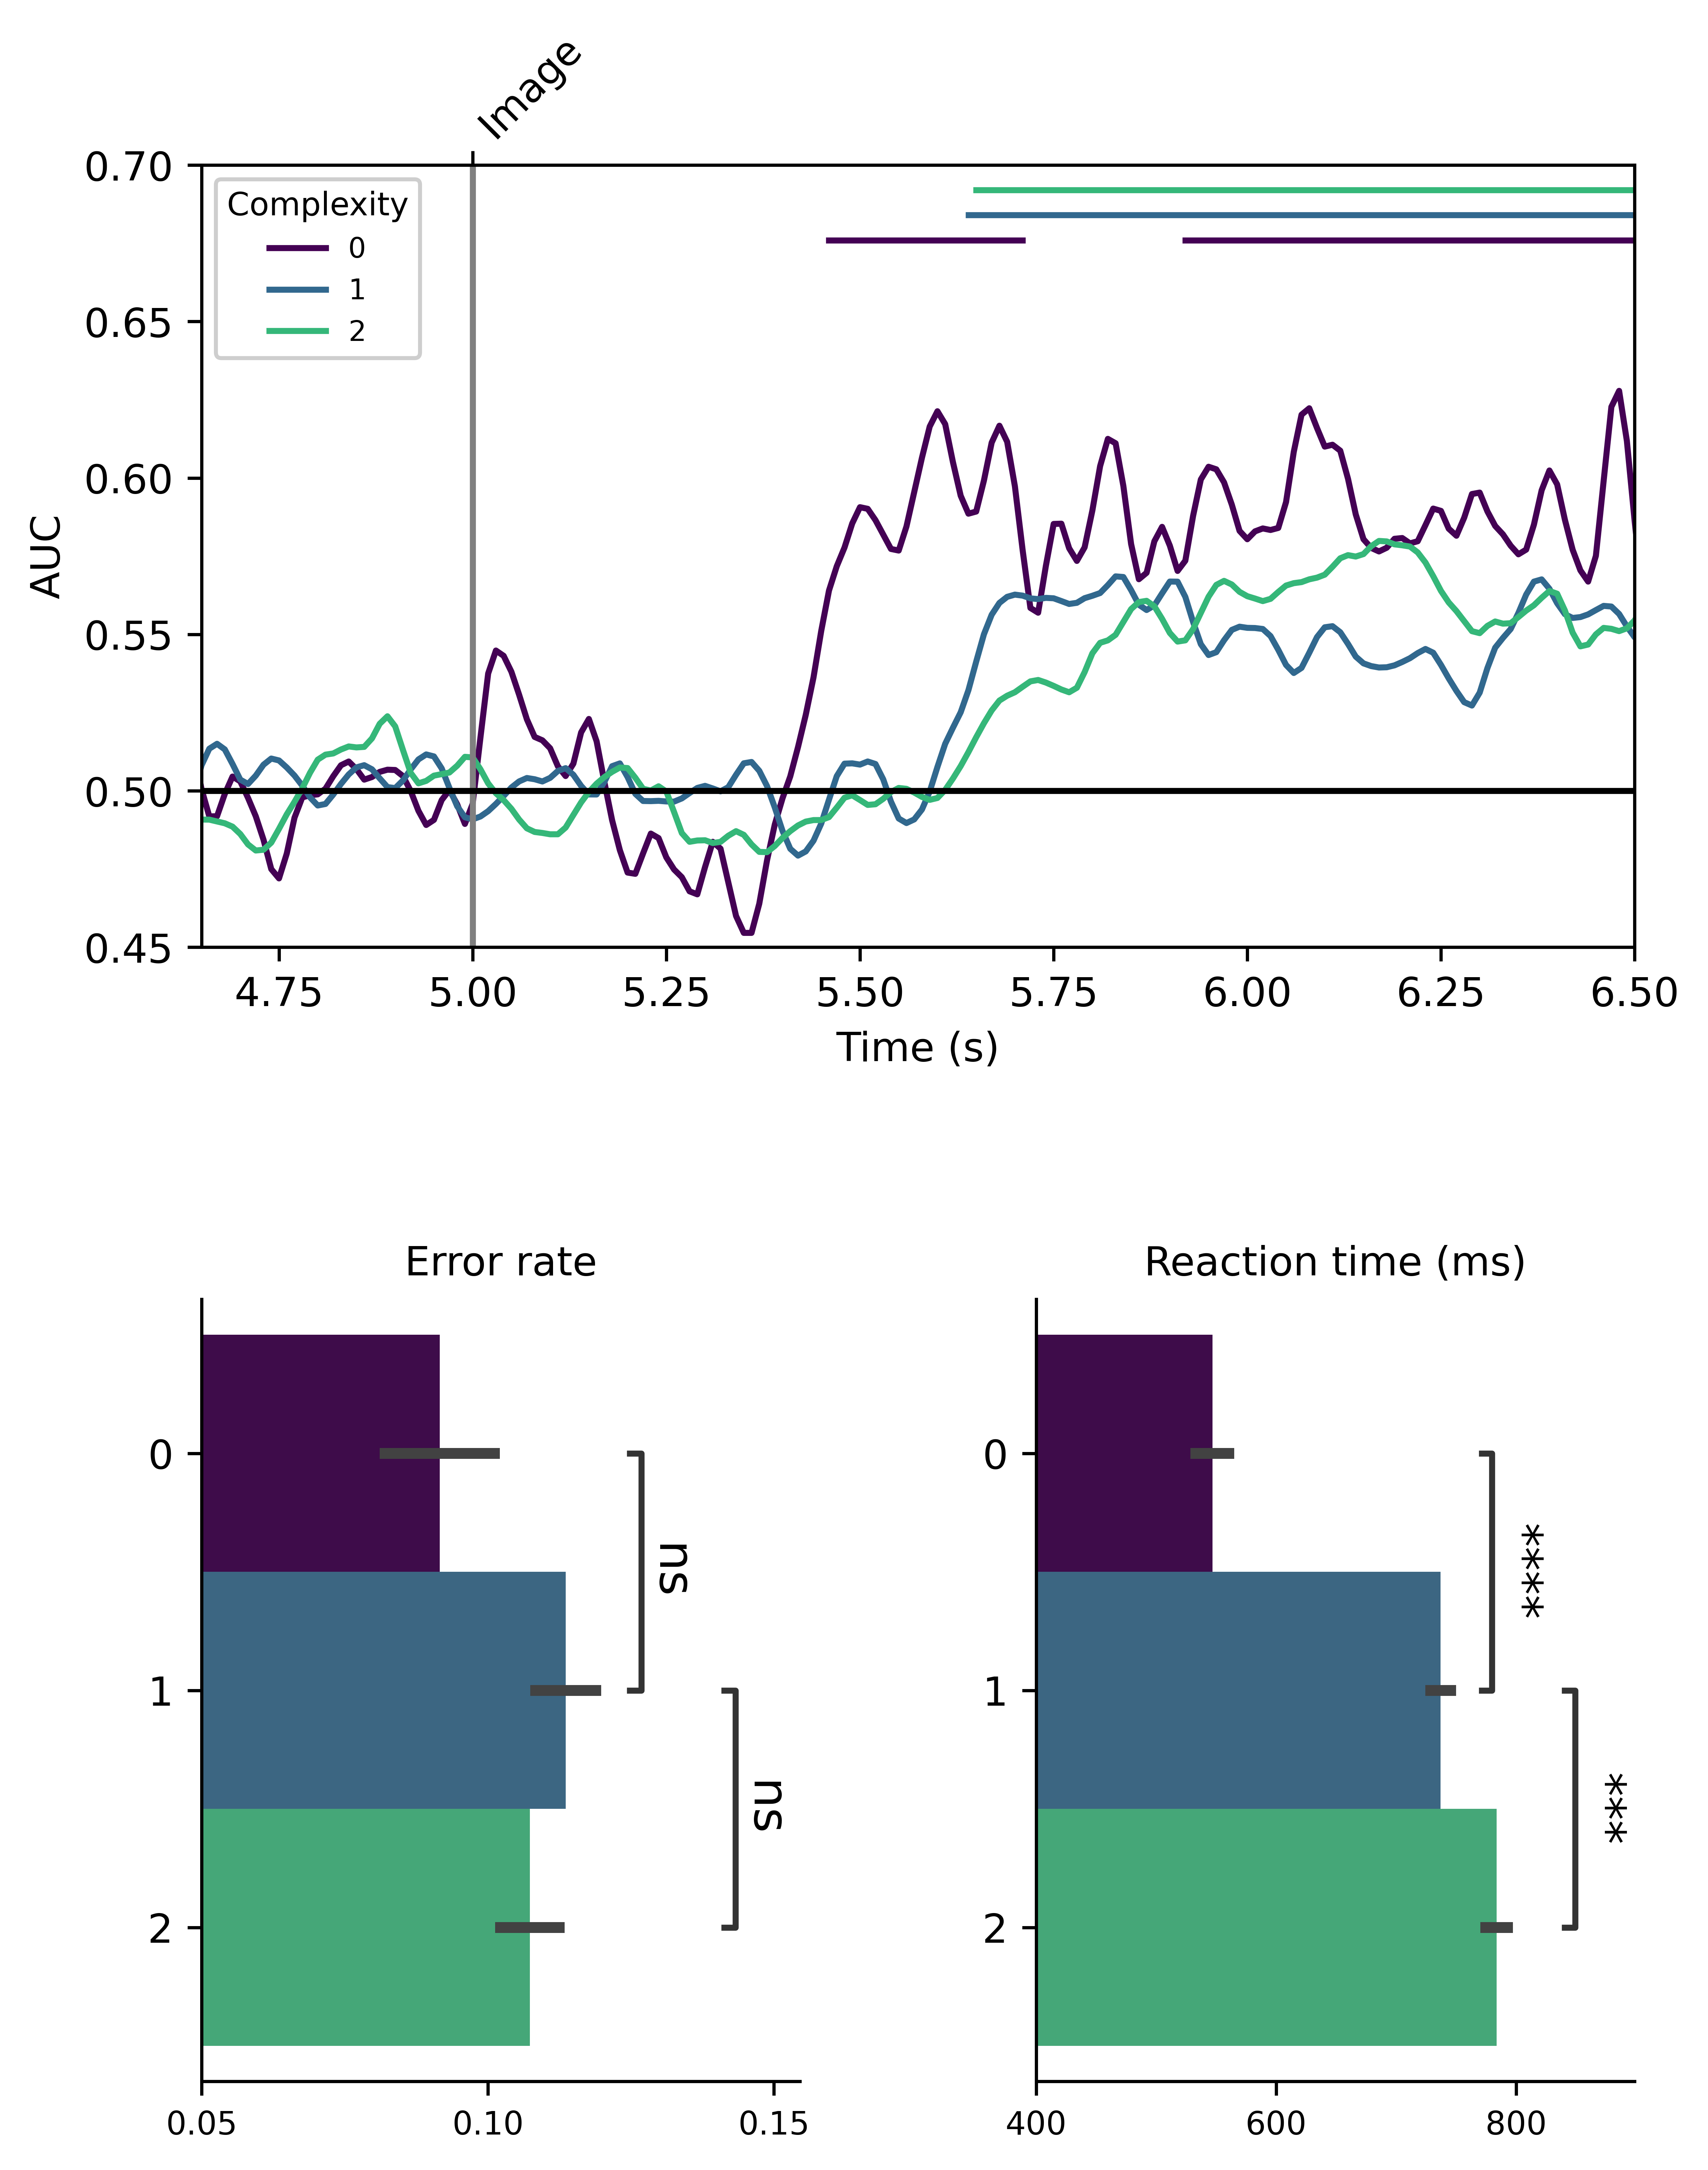

In [199]:
## Decoding at readout plot COMPLEXITY
fig = plt.figure(constrained_layout=False, dpi=800, figsize=(6,8))
# axes = fig.subplot_mosaic("""BB
#                              AA
#                              CD""")
axes = fig.subplot_mosaic("""AA
                             CD""")
lgd_sz = 7
ftsz = 10
plot_kind = "bar"
perf_ymin = .05
rt_ymin = 400
tmin = 4.65
tmax = 6.5

def update_fontsize(ax, ftsz):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(ftsz)

        
# First = motor decoding
        
conds = ["Matching_scenes_None__for_Complexity=0", "Matching_scenes_None__for_Complexity=1", "Matching_scenes_None__for_Complexity=2"]
ymin, ymax = .45, .7
ax_comp = axes["A"]
# conds = ["PropMismatch_scenes_None__for_Complexity=0", "PropMismatch_scenes_None__for_Complexity=1", "PropMismatch_scenes_None__for_Complexity=2"]
for i, cond in enumerate(conds):
    dat = smooth(mne.baseline.rescale(np.mean(all_diags[cond], 0), times, baseline=(4.5, 5)) + 0.5, 7)
    dat = np.roll(dat, -12+i*14)
    line = ax_comp.plot(times, dat, label=cond[-1], color=cmap_gfp(i))
    _, clusters, cluster_pvals, H0 = permutation_cluster_1samp_test(np.roll(all_diags[cond]-.5, -12+i*14), 
                n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='indices')
    for cluster, pval in zip(clusters, cluster_pvals):
        if pval < .05:
            print(f"found cluster for {cond}: {times[cluster[0][0]]}, {times[cluster[0][-1]]}")
            ax_comp.plot([times[cluster[0][0]], times[cluster[0][-1]]], [ymax-.024+i*0.008, ymax-.024+i*0.008], color=line[0].get_color())
ax_comp.set_xlabel("Time (s)")
ax_comp.set_ylabel("AUC")
ax_comp.set_xlim(tmin,tmax)
ax_comp.set_ylim(ymin, ymax)
ax_comp.axvline(x=5, color='grey')
ax_comp.axhline(y=.5, xmin=0, xmax=1, color='k')
secax_x = add_sent_on_top(ax_comp, [], image_onset, colors=[], sent_type='img', fontsize=ftsz, mksz=sent_mksz)
secax_x.spines['top'].set_visible(False)
leg = ax_comp.legend(loc="upper left", title="Complexity", prop={'size': lgd_sz}, title_fontsize=ftsz-2, framealpha=.95) # inside

## behavior
box_pairs = [[0, 1], [1, 2]]
colors = {0: cmap_gfp(0), 1: cmap_gfp(1), 2: cmap_gfp(2)}
make_sns_barplot(results_2obj, x="Complexity", y="Error rate", ax=axes["C"], ymin=perf_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, colors=colors) # colors=['k'])
make_sns_barplot(results_2obj.query("Perf==1"), x="Complexity", y="RT", ax=axes["D"], ymin=rt_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, colors=colors) #, colors=['k', 'k'])

for ax in [axes["C"], axes["D"]]:
    if ax.get_xlabel() == "RT":
        ax.set_title("Reaction time (ms)")
    else:
        ax.set_title(ax.get_xlabel())
    ax.set_xlabel("") # remove xlabel
    ax.set_ylabel("") # remove xlabel

for ax in axes.values(): # update to final fontsize (seaborn fucks things uop if specified otherwise)
    update_fontsize(ax, ftsz)
for item in axes["C"].get_xticklabels() + axes["D"].get_xticklabels():
    item.set_fontsize(ftsz-2) # a bit smaller to git the space

plt.subplots_adjust(hspace=0.45) #, hspace=hspace)
fig.savefig("./readout_complexity_plot.png", transparent=True, bbox_inches='tight', dpi=400)

Applying baseline correction (mode: mean)
found cluster for PropMismatch_scenes_None_: 5.45, 6.75
Applying baseline correction (mode: mean)
found cluster for BindMismatch_scenes_None_: 5.48, 6.89
found cluster for BindMismatch_scenes_None_: 6.91, 7.39
Applying baseline correction (mode: mean)
found cluster for RelMismatch_scenes_None_: 5.61, 8.0


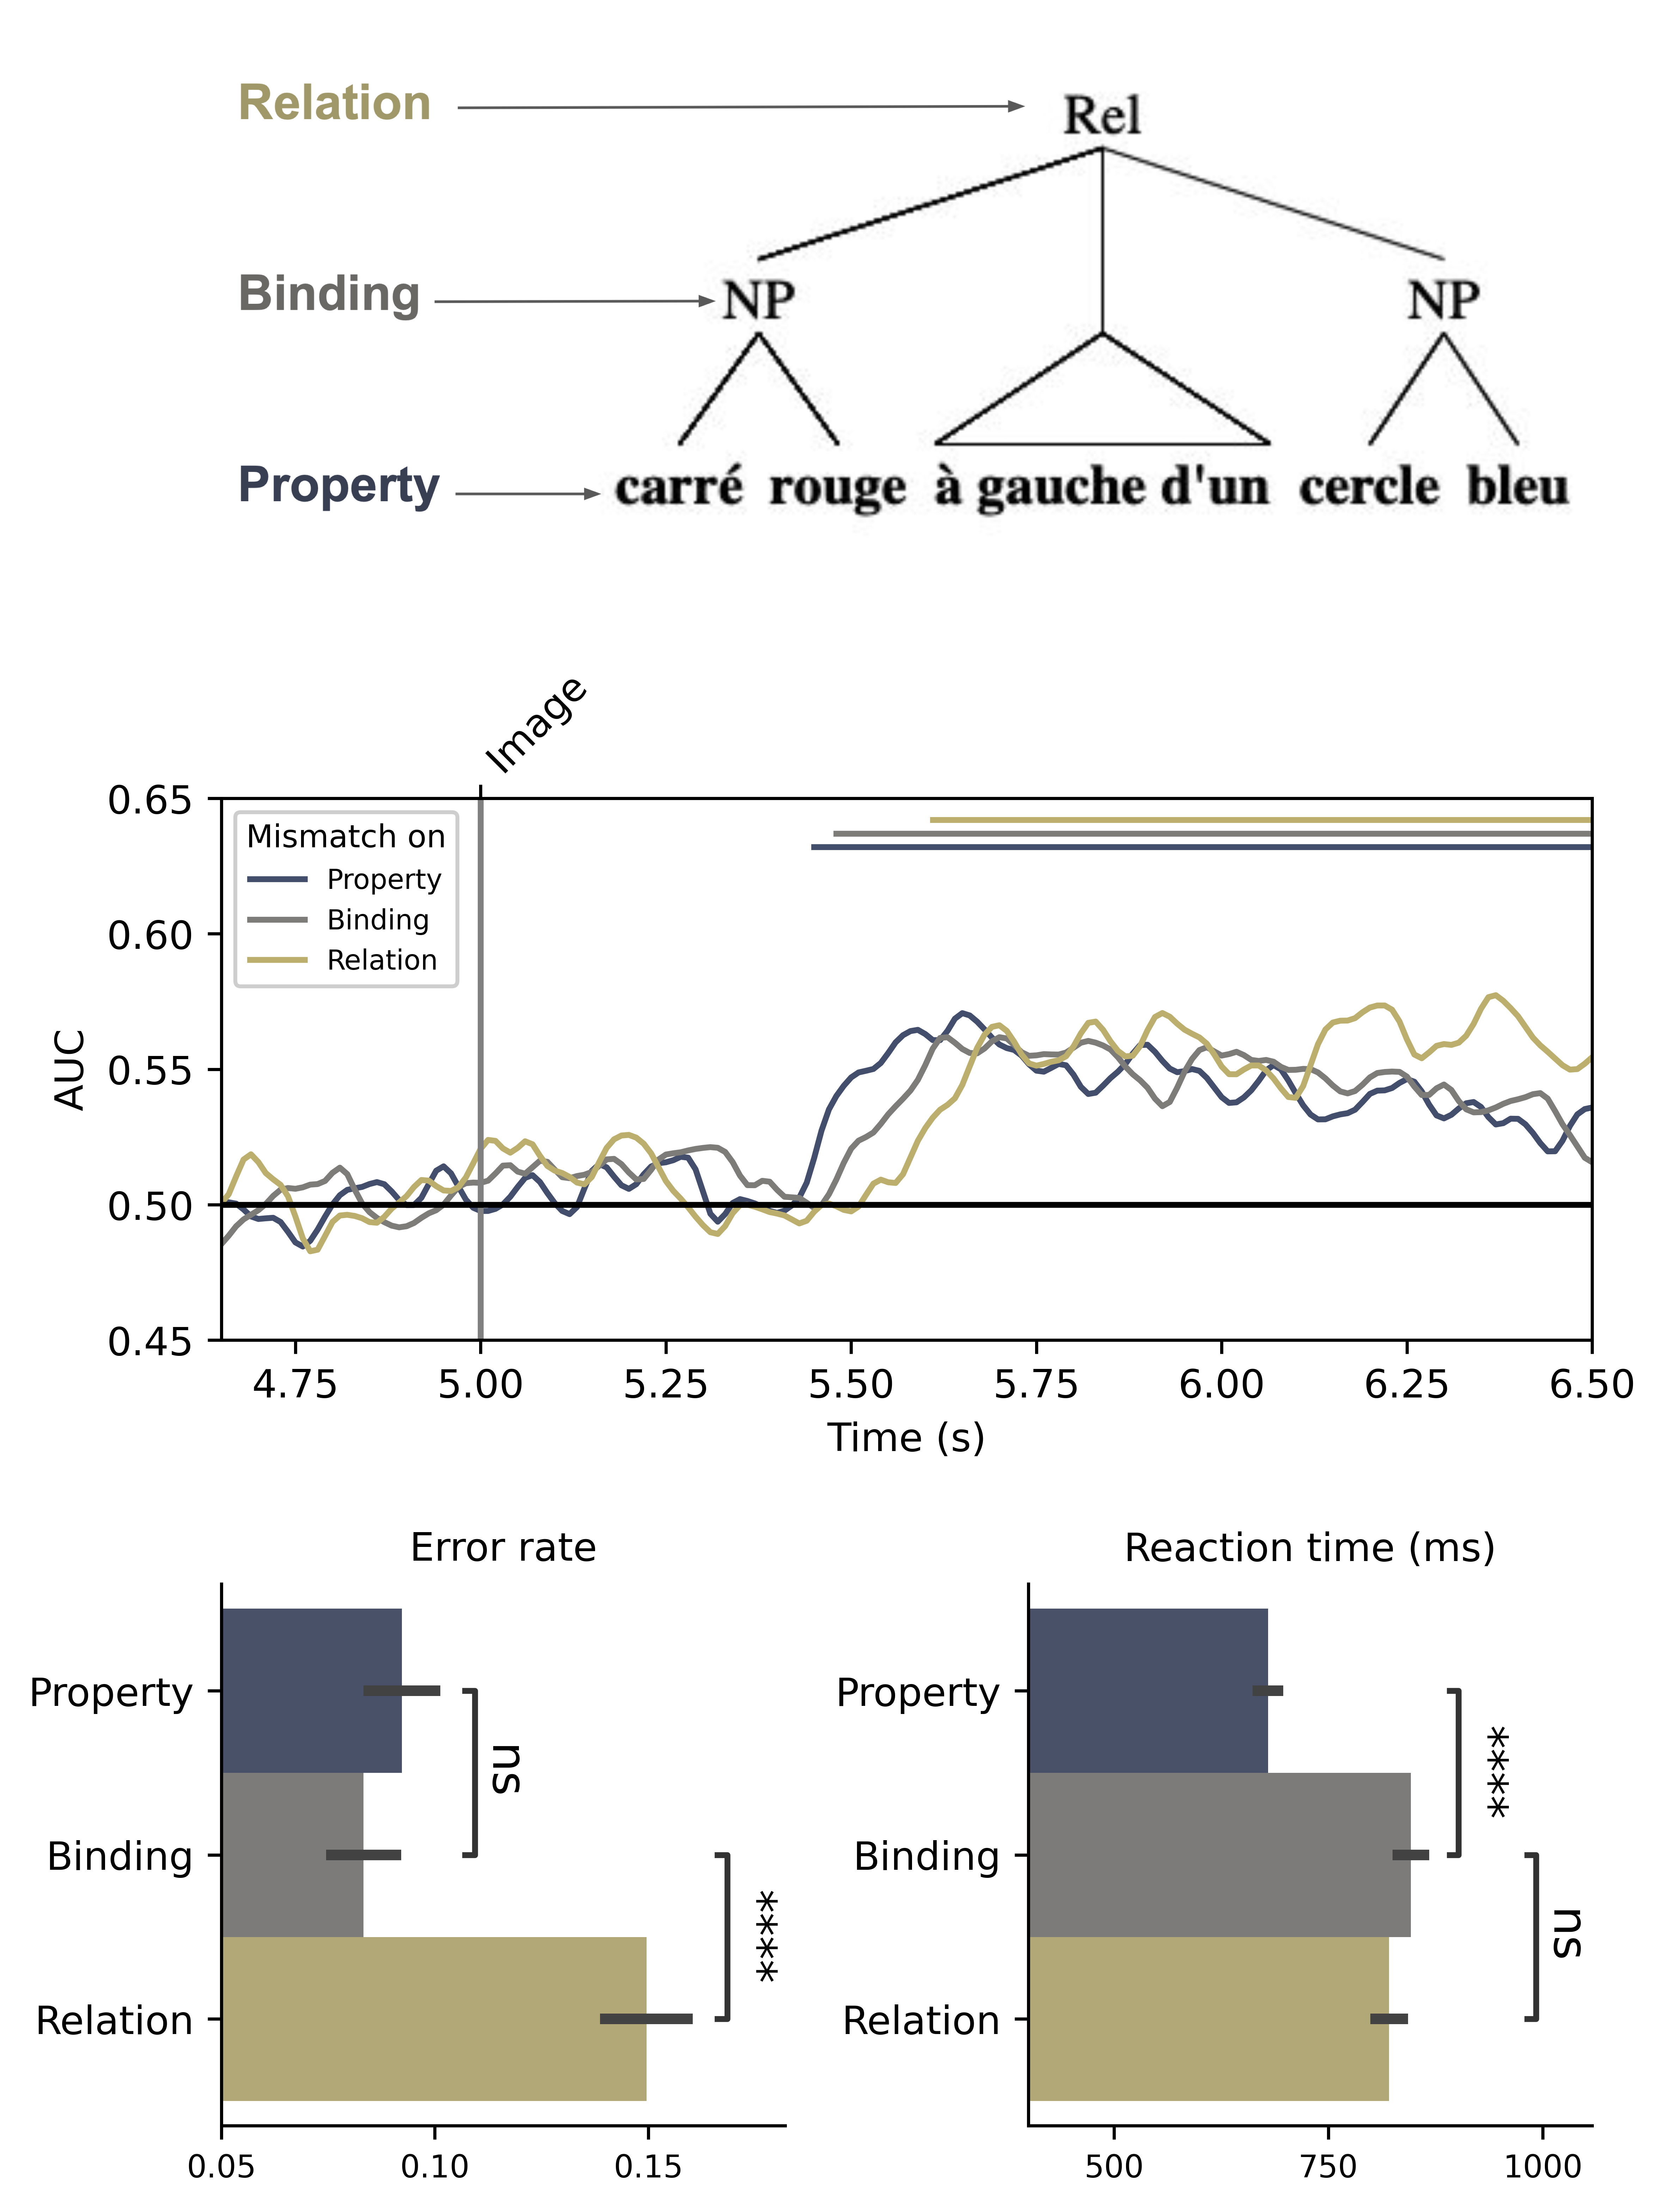

In [194]:
## Decoding at readout plot MISMATCHES
fig = plt.figure(constrained_layout=False, dpi=800, figsize=(6,8))
axes = fig.subplot_mosaic("""AA
                             BB
                             CD""")
lgd_sz = 7
ftsz = 10
plot_kind = "bar"
perf_ymin = .05
rt_ymin = 400
tmin = 4.65
tmax = 6.5

## First: image of the tree 
ax_img = axes["A"]
ax_img.axis('off')
im = pimg.imread("./treef.png")
ax_img.imshow(im)
        
cmap_mis = plt.get_cmap("cividis", 5)
conds = ["PropMismatch_scenes_None_", "BindMismatch_scenes_None_", "RelMismatch_scenes_None_"]
ymin, ymax = .45, .65
ax_mism = axes["B"]
for i, cond in enumerate(conds):
    dat = smooth(mne.baseline.rescale(np.mean(all_diags[cond], 0), times, baseline=(4.5, 5)) + 0.5, 7)
    label = to_full[cond[0:3] if "Rel" in cond else cond[0:4]]
    line = ax_mism.plot(times, dat, label=label, color=cmap_mis(i+1))
    _, clusters, cluster_pvals, H0 = permutation_cluster_1samp_test(all_diags[cond]-.5, 
                                    n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='indices')
    for cluster, pval in zip(clusters, cluster_pvals):
        if pval < .05:
            print(f"found cluster for {cond}: {times[cluster[0][0]]}, {times[cluster[0][-1]]}")
            ax_mism.plot([times[cluster[0][0]], times[cluster[0][-1]]], [ymax-.018+i*0.005, ymax-.018+i*0.005], color=line[0].get_color())
ax_mism.set_xlim(tmin,tmax)
ax_mism.set_ylim(ymin, ymax)
ax_mism.axvline(x=5, color='grey')
ax_mism.axhline(y=.5, xmin=0, xmax=1, color='k')
ax_mism.set_xlabel("Time (s)")
ax_mism.set_ylabel("AUC")
secax_x = add_sent_on_top(ax_mism, [], image_onset, colors=[], sent_type='img', fontsize=ftsz, mksz=sent_mksz)
secax_x.spines['top'].set_visible(False)
leg = ax_mism.legend(loc="upper left", title="Mismatch on", prop={'size': lgd_sz}, title_fontsize=ftsz-2, framealpha=.95) # inside

## behavior
order = ["Property", "Binding", "Relation"] # "None", 
box_pairs = [["Property", "Binding"], ["Binding", "Relation"]]
colors = {"None": 'k', "Property": cmap_mis(1), "Binding": cmap_mis(2), "Relation": cmap_mis(3)}
make_sns_barplot(results_2obj, x="Mismatch on", y="Error rate", ax=axes["C"], ymin=perf_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, order=order, colors=colors) 
make_sns_barplot(results_2obj.query("Perf==1"), x="Mismatch on", y="RT", ax=axes["D"], ymin=rt_ymin, hue=None, box_pairs=box_pairs, kind=plot_kind, order=order, colors=colors)

for ax in [axes["C"], axes["D"]]:
    if ax.get_xlabel() == "RT":
        ax.set_title("Reaction time (ms)")
    else:
        ax.set_title(ax.get_xlabel())
    ax.set_xlabel("") # remove xlabel
    ax.set_ylabel("") # remove xlabel

for ax in axes.values(): # update to final fontsize (seaborn fucks things uop if specified otherwise)
    update_fontsize(ax, ftsz)
for item in axes["C"].get_xticklabels() + axes["D"].get_xticklabels():
    item.set_fontsize(ftsz-2) # a bit smaller to git the space


plt.tight_layout()
plt.subplots_adjust(hspace=0.45) #, hspace=hspace)
fig.savefig("./readout_mismatches_plot.png", transparent=True, bbox_inches='tight', dpi=400)

In [ ]:
# # LOAD ALL DATA
# ## Figure on decoding each property
# fn = "./Decoding_ovr_v29_ALL/all_data.p"
# all_data = pickle.load(open(fn, "rb"))
# print(all_data.keys())

In [ ]:
# ## get best timepoints for shape decoding tested on scenes and plot it all on the same graph.
# vmin, vcenter, vmax = 0.4, 0.5, 0.6
# divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# shape1_fig = plt.figure(dpi=200)
# for cond, times_train in zip(["S_1_localizer_scenes_", "S_0_obj_scenes_", "S1_scenes_None_"], [times_loc, times_obj, times_scenes]):
# #     print(all_data["S_1_localizer_scenes_"].shape) # nsubs*ntimes_loc*ntimes_scenes
#     best_tp = np.argmax(all_data[cond].mean(0).max(1)) # average over subjects and test timepoints
# #     print(best_tp)
#     slice_data = get_slice(all_data[cond].mean(0), times_train, times_train[best_tp], slice_ave=5, dim=0)
#     plt.plot(times_scenes, slice_data, label=cond)    
# #     fig, axes = plt.subplots(2, dpi=200)
# #     extent = [min(times_scenes), max(times_scenes), min(times_train), max(times_train)] # times_test, times_train    
# #     axes[0].imshow(all_data[cond].mean(0), norm=divnorm, cmap='bwr', origin='lower', extent=extent, zorder=0)
# #     axes[0].axhline(y=times_loc[best_tp], xmin=times_scenes[0], xmax=times_scenes[-1])
# #     axes[1].plot(times_scenes, all_data[cond].mean(0)[best_tp])
# plt.hlines(y=.5, xmin=times_scenes[0], xmax=times_scenes[-1], color='k')
# plt.legend()


# color1_fig = plt.figure(dpi=200)
# for cond, times_train in zip(["C_1_localizer_scenes_", "C_0_obj_scenes_", "C1_scenes_None_"], [times_loc, times_obj, times_scenes]):
# #     print(all_data["S_1_localizer_scenes_"].shape) # nsubs*ntimes_loc*ntimes_scenes
#     best_tp = np.argmax(all_data[cond].mean(0).max(1)) # average over subjects and test timepoints
# #     print(best_tp)
#     slice_data = get_slice(all_data[cond].mean(0), times_train, times_train[best_tp], slice_ave=5, dim=0)
#     plt.plot(times_scenes, slice_data, label=cond)    
# plt.hlines(y=.5, xmin=times_scenes[0], xmax=times_scenes[-1], color='k')
# plt.legend()


# shape2_fig = plt.figure(dpi=200)
# for cond, times_train in zip(["S_2_localizer_scenes_", "S_1_obj_scenes_", "S2_scenes_None_"], [times_loc, times_obj, times_scenes]):
# #     print(all_data["S_1_localizer_scenes_"].shape) # nsubs*ntimes_loc*ntimes_scenes
#     best_tp = np.argmax(all_data[cond].mean(0).max(1)) # average over subjects and test timepoints
# #     print(best_tp)
#     slice_data = get_slice(all_data[cond].mean(0), times_train, times_train[best_tp], slice_ave=5, dim=0)
#     plt.plot(times_scenes, slice_data, label=cond)    
# plt.hlines(y=.5, xmin=times_scenes[0], xmax=times_scenes[-1], color='k')
# plt.legend()

# color2_fig = plt.figure(dpi=200)
# for cond, times_train in zip(["C_2_localizer_scenes_", "C_1_obj_scenes_", "C2_scenes_None_"], [times_loc, times_obj, times_scenes]):
# #     print(all_data["S_1_localizer_scenes_"].shape) # nsubs*ntimes_loc*ntimes_scenes
#     best_tp = np.argmax(all_data[cond].mean(0).max(1)) # average over subjects and test timepoints
# #     print(best_tp)
#     slice_data = get_slice(all_data[cond].mean(0), times_train, times_train[best_tp], slice_ave=5, dim=0)
#     plt.plot(times_scenes, slice_data, label=cond)    
# plt.hlines(y=.5, xmin=times_scenes[0], xmax=times_scenes[-1], color='k')
# plt.legend()

In [ ]:
# ## ALL SUBJECTS Evokeds plots loading data -- naze
# # fns = [ "complexities-all_subs-evos.p",
# #         "complexities-grand-evos.p",
# #        "all_subs-evos.p",
# #        "grand-evos.p"]
# # comp_all_subs_evos = pickle.load(open(f"./evo_data/{fns[0]}", "rb"))
# # comp_grand_evos = pickle.load(open(f"./evo_data/{fns[1]}", "rb"))
# # all_subs_evo = pickle.load(open(f"./evo_data/{fns[2]}", "rb"))
# # grand_evo = pickle.load(open(f"./evo_data/{fns[3]}", "rb"))
# complexities = ['0','1','2']
# fns = [ "./evo_data/data/complexity0-*-ave.fif",
#         "./evo_data/data/complexity1-*-ave.fif",
#         "./evo_data/data/complexity2-*-ave.fif"]

# all_subs_comps = {}
# for comp, fn in zip (complexities, fns):
#     comp_fns = sorted(glob(fn))
#     all_subs_comps[comp] = []
#     for comp_fn in comp_fns:
#         all_subs_comps[comp].append(mne.read_evokeds(comp_fn, verbose=False)[0])
# # all_subs_comps

In [ ]:
# def get_signif(all_subs_data1, all_subs_data2, stat):
#     ## all_subs_data should be (n_subs, n_times)
# #     assert len(all_subs_data1.shape)==2, f"all_subs_data should be of shape (n_subs, n_times) but found {all_subs_data1.shape}"
#     n_subs, n_times = all_subs_data1.shape
#     if stat == "cluster": # for cluster perm test we store the clusters and corresponding pvalues
#         fvalues, clusters, cluster_pvals, H0 = permutation_cluster_test(all_subs_data, all_subs_data2, 
#                                         n_permutations=1000, threshold=None, tail=1, n_jobs=5, verbose=False, seed=42, out_type='mask')
#         signif = np.ones(n_times)
#         for cluster, cluster_pval in zip(clusters, cluster_pvals):
#             if cluster_pval < 0.05:
#                 signif[cluster] = 0
#                 # print(f"signif cluster for {times[i_dat][cluster][0]:.02} to {times[i_dat][cluster][-1]:.02}s, pval={cluster_pval}")
#     elif stat == "wilcoxon": # for wilcoxon we only store the pvalue for each timesample
#         signif = np.zeros(n_times)
#         for t in range(n_times):
#             np.random.seed(seed=233423)
#             # try:
#             signif[t] = wilcoxon(all_subs_data1[:, t], all_subs_data2[:, t], alternative="two-sided")[1] #two-sided
#             # except ValueError: # ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.
#             #     print("pwet")
#             #     signif[t] = 1
#     else: 
#         raise RuntimeError(f"Unknown stat method to get significant timepoints: {stat}")
#     signif = fdr_correction(np.array(signif), alpha=0.05)[0]
#     return signif

In [195]:
# ## cluster perm test -- naze
# fig, ax = plt.subplots(dpi=400)
# times = comp_grand_evos[0].times
# dat0 = get_gfp(deepcopy(comp_grand_evos[0]).pick('mag'))
# dat1 = get_gfp(deepcopy(comp_grand_evos[1]).pick('mag'))
# dat2 = get_gfp(deepcopy(comp_grand_evos[2]).pick('mag'))
# tiles = 4
# dat0 = np.tile(dat0, (tiles, 1))
# dat1 = np.tile(dat1, (tiles, 1))
# dat2 = np.tile(dat2, (tiles, 1))
# # print(dat0.shape)

# # dat0 = get_gfp_array(np.array([deepcopy(e).pick('mag').data for e in all_subs_comps['0']]), times)
# # dat2 = get_gfp_array(np.array([deepcopy(e).pick('mag').data for e in all_subs_comps['2']]), times)

# signif = get_signif(dat0, dat2, stat='wilcoxon')

# # dat0 = np.concatenate([deepcopy(e).pick('mag').data for e in all_subs_comps['0']])
# # dat1 = np.concatenate([deepcopy(e).pick('mag').data for e in all_subs_comps['1']])
# # dat0 = np.concatenate([deepcopy(e)[f"Complexity==0"].get_data() for e in all_subs_comps])
# # dat1 = np.concatenate([deepcopy(e)[f"Complexity==1"].get_data() for e in all_subs_comps])
# # dat2 = np.concatenate([deepcopy(e)[f"Complexity==2"].get_data() for e in all_subs_epochs])
# # _, clusters0, pclusters0, h0 = mne.stats.permutation_cluster_test([dat0, dat2], threshold=None, n_permutations=1024) #, out_type='mask')

# # _, clusters1, pclusters1, h0 = mne.stats.permutation_cluster_test([dat_meds['1'], dat_meds['2']], threshold=None, n_permutations=1024, out_type='mask')
# # for i, complexity in enumerate(['0','1','2']):


# # # # gfp, then median -> nope
# # plt.plot(times, np.median([get_gfp(deepcopy(e).pick('grad')) for e in all_subs_comps['0']], 0), label='0')
# # plt.plot(times, np.median([get_gfp(deepcopy(e).pick('grad')) for e in all_subs_comps['1']], 0), label='1')
# # plt.plot(times, np.median([get_gfp(deepcopy(e).pick('grad')) for e in all_subs_comps['2']], 0), label='2')

# # median then gfp, exacly the same as the following
# # plt.plot(times, get_gfp_array(np.median([deepcopy(e).pick('mag').data for e in all_subs_comps['0']], 0), times), label='0')
# # plt.plot(times, get_gfp_array(np.median([deepcopy(e).pick('mag').data for e in all_subs_comps['1']], 0), times), label='1')
# # plt.plot(times, get_gfp_array(np.median([deepcopy(e).pick('mag').data for e in all_subs_comps['2']], 0), times), label='2')

# ## gfp on the grand data, exactly as the mne func
# plt.plot(times, get_gfp(deepcopy(comp_grand_evos[0]).pick('mag')), label='0')
# plt.plot(times, get_gfp(deepcopy(comp_grand_evos[1]).pick('mag')), label='1')
# plt.plot(times, get_gfp(deepcopy(comp_grand_evos[2]).pick('mag')), label='2')

# # y = np.max(dat0)
# # for cluster, pval in zip(clusters0, pclusters0):
# #     if pval < 0.05:
# # #         print("pwet")
# #         plt.hlines(y, times[cluster[0][0]], times[cluster[0][-1]])

# # print(clusters0)
# # print(pclusters0)
# # dat0.shape

In [196]:
# print(signif)
# print(pclusters0)
# dat0.shape

In [197]:
# adjacency, ch_names = mne.channels.find_ch_adjacency(comp_grand_evos[0][0].info, ch_type='mag')


In [198]:
# from cop;exiry fig 
# nreps, scale = 30, 1e-13
# dat0 = get_gfp(deepcopy(comp_grand_evos[0][0]).pick('mag'))[:, np.newaxis]
# dat0 = np.tile(dat0, nreps).T
# dat0 = dat0 + np.random.normal(size=dat0.shape) * scale
# dat1 = get_gfp(deepcopy(comp_grand_evos[1][0]).pick('mag'))[:, np.newaxis]
# dat1 = np.tile(dat1, nreps).T
# dat2 = get_gfp(deepcopy(comp_grand_evos[2][0]).pick('mag'))[:, np.newaxis]
# dat2 = np.tile(dat2, nreps).T
# dat2 = dat2 + np.random.normal(size=dat2.shape) * scale
# print(dat0.shape)
# _, clusters, cluster_pvals, H0 = permutation_cluster_test([dat0, dat2], 
#                                 n_permutations=1000, threshold=0, tail=0, n_jobs=5, verbose=False, seed=42, out_type='indices')
# for cluster, pval in zip(clusters, cluster_pvals):
#     if pval < 0.05: 
#         print(cluster)
#         print(pval)
# l1 = ax_gfp.plot([3.8, 4.66], [ymax-10, ymax-10], color='green', lw=3) ## 0-1
# l2 = ax_gfp.plot([3.8, 4.66], [ymax-10, ymax-10], linestyle='--', color='blue', dashes=[1.5, 1.5], lw=3)
# l1 = ax_gfp.plot([4.35, 4.65], [ymax-8, ymax-8], color='green', lw=3) ## 1-2
# l2 = ax_gfp.plot([4.35, 4.65], [ymax-8, ymax-8], linestyle='--', color='orange', dashes=[1.5, 1.5], lw=3)